# Telegram Analysis

## Prepare environment

In [1]:
"""
Set flag to true, if you work in visual studio code (connected to custom docker)
Set flag to false, if you work in browser (jupyter notebook ui from custom docker)
"""
FLAG_LOCAL              = True

"""
Set flag to true, if you want process no long term running tasks
"""
FLAG_SHORT_RUN          = True

"""
Load DataSets
Ava:    ["dataSet0", "dataSet1", "dataSet1a"]
Req:    ["dataSet0]
"""
C_LOAD_DATASET          = ["dataSet0"]

In [2]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Import url libs
from urllib.parse import urlparse
from collections import Counter
import requests

# File Handler Lib
from pathlib import Path

# Set graph widget (used by jupyter notebook)
#%matplotlib notebook   #interactive graphs
%matplotlib inline

In [3]:
# Install and import Graph Lib
import networkx as nx
#! pip install pydot

In [4]:
# Install and import  JSON Lib
#! pip install demjson
import demjson

In [5]:
# Install and import Natural Language Toolkit
#! pip install nltk
import nltk

# Ngrams
import re
from nltk.util import ngrams

# Stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Gensim and pyLDAvis
#! pip install gensim
#! pip install pyLDAvis

import gensim

from gensim.utils import simple_preprocess

import gensim.corpora as corpora

from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis

import os

# TODO Set to ignore?
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("once")

In [7]:
# Install and import demoji
# Dont exists on conda
import sys
!{sys.executable} -m pip install demoji

import demoji
demoji.download_codes()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


... OK (Got response in 0.44 seconds)
Writing emoji data to /home/jovyan/.demoji/codes.json ...
... OK


In [8]:
# Install and import WordCloud
#! pip install wordcloud
from wordcloud import WordCloud

/opt/conda/lib/python3.8/site-packages/wordcloud/wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='/opt/conda/lib/python3.8/site-packages/wordcloud/stopwords' mode='r' encoding='UTF-8'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


In [9]:
# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

In [10]:
# Set env vars
if(FLAG_LOCAL == True):
    dir_var = "./work/notebooks/"
else:
    dir_var = "./"

dir_var_output = dir_var + "output/"

dir_var_cache= dir_var + "cache/"

# Debug output
! echo "- Workdir -"
! ls -al $dir_var

! echo
! echo "- Outputdir -"
! ls -al $dir_var_output

! echo
! echo "- Cachedir -"
! ls -al $dir_var_cache

- Workdir -
total 140
drwxrwxr-x 6 jovyan  1000   4096 Jan 12 08:55 .
drwxrwxr-x 6 jovyan  1000   4096 Jan  8 14:24 ..
drwxrwxr-x 2 jovyan  1000   4096 Jan 12 08:54 cache
drwxrwxr-x 6 jovyan  1000   4096 Jan  5 15:29 data
-rw-rw-r-- 1 jovyan  1000  11400 Jan 11 14:35 inputFiles.csv
drwxr-xr-x 2 jovyan users   4096 Jan  3 11:12 .ipynb_checkpoints
drwxrwxr-x 4 jovyan  1000   4096 Jan 12 08:54 output
-rwxrwxr-x 1 jovyan  1000 105861 Jan 12 08:55 Telegram.ipynb

- Outputdir -
total 24
drwxrwxr-x 4 jovyan 1000  4096 Jan 12 08:54 .
drwxrwxr-x 6 jovyan 1000  4096 Jan 12 08:55 ..
drwxrwxr-x 2 jovyan 1000 12288 Jan 12 08:54 autoWordCloud
-rw-rw-r-- 1 jovyan 1000     0 Jan  3 10:43 .gitkeep
drwxrwxr-x 2 jovyan 1000  4096 Jan 12 08:54 pyLDAvis

- Cachedir -
total 144
drwxrwxr-x 2 jovyan 1000   4096 Jan 12 08:54 .
drwxrwxr-x 6 jovyan 1000   4096 Jan 12 08:55 ..
-rw-rw-r-- 1 jovyan 1000      0 Jan  4 14:37 .gitkeep
-rw-rw-r-- 1 jovyan 1000 136703 Jan 12 08:54 resolved-urls.csv


### Global functions

In [11]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

In [12]:
"""
Check if text is json formatted

param   text        InputText
param   singleMode  Boolean (set to true, if text is part of a message)
"""
def gloCheckIsTextJsonFormatted(text, singleMode):
    textString = str(text)
    if      (singleMode == False and textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    elif    (singleMode == True and textString.startswith("{") == True and textString.endswith("}") == True):
        return True
    else:
        return False

In [13]:
# Rm unsafe chars
def gloConvertToSafeString(text):
    text = text.encode('ascii', 'ignore')
    text = text.decode('ascii')
    return text

# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = gloConvertToSafeString(chatName)
    return chatName[:30]

In [14]:
# Write dict to file (CSV)
def gloWriteDictToFile(filename, targetDict):
    d = pd.DataFrame.from_dict(targetDict, orient="index")
    d.to_csv(dir_var_cache + filename, header=False)

# Read dict from file (CSV)
def gloReadDictFromFile(filename):
    d = pd.read_csv(dir_var_cache + filename, header=None, index_col=0, squeeze=True)
    return d.to_dict()

# Init csv file if not exists
def gloInitFileDict(filename):
    f = Path(dir_var_cache + filename)
    if(f.exists() == False):
        print("Init cache file >>" + filename + "<<")
        f.touch()
        gloWriteDictToFile(filename, {"initKey": "initValue"})
    else:
        print("Cache already exists >>" + filename + "<<")

In [15]:
# Check if is already cached
def gloCheckIsAlreadyCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    if(targetKey in targetDict.keys()):
        return True
    else:
        return False

# Add key to cache
def gloAddToCache(filename, targetKey, targetValue):
    targetDict = gloReadDictFromFile(filename)
    targetDict[targetKey] = targetValue
    gloWriteDictToFile(filename, targetDict)

# Get key from cache
def gloGetCached(filename, targetKey):
    targetDict = gloReadDictFromFile(filename)
    return targetDict[targetKey]

#### Init Cache Files

In [16]:
gloInitFileDict("resolved-urls.csv")

Cache already exists >>resolved-urls.csv<<


## Process input jobs

In [17]:
gloStartStopwatch("Global notebook")

[Stopwatch started >>Global notebook<<]


In [18]:
# Read jobs from file
dfInputFiles = pd.read_csv(dir_var + "inputFiles.csv", sep=";")

In [19]:
dfFilter = pd.DataFrame()

for dS in C_LOAD_DATASET:
    dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputDesc == dS])

dfInputFiles = dfFilter

### Overview input jobs

In [20]:
dfInputFiles

inputName  \
47              ATTILA HILDMANN   
48    Oliver Janich oeffentlich   
49         Eva Herman Offiziell   
50  Xavier Naidoo (inoffiziell)   

                                        inputPath       inputType  \
47   DS-05-01-2021/ChatExport_2021-01-05-hildmann  public_channel   
48     DS-05-01-2021/ChatExport_2021-01-05-janich  public_channel   
49  DS-05-01-2021/ChatExport_2021-01-05-evaherman  public_channel   
50     DS-05-01-2021/ChatExport_2021-01-05-xavier  public_channel   

        inputId inputDesc inputDownloadType  
47  10034163583  dataSet0          onlyText  
48   9808932799  dataSet0          onlyText  
49   9915108907  dataSet0          onlyText  
50   9874390332  dataSet0          onlyText

### Transform data into DataFrmaes

In [21]:
# Convert to DataFrame Meta (Chat Meta)
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + "data/" + filePath + "/result.json", encoding='utf-8')
    return dF

# Convert to DataFrame Messages (Chat Messages)
def convertToDataFrameMessages(filePath):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
"""
Get params from extractedTextData
See cell below (key)
"""
def getExtractedTextDataParam(key, extractedTextData):
    a,b,c,d,e,f,g = extractedTextData
    switcher = {
        0: a,
        1: b,
        2: c,
        3: d,
        4: e,
        5: f,
        6: g
    }
    return switcher.get(key)

In [23]:
# TODO: href, mention and hashtags in normal text?

"""
Extract text data (see cell above key)
See cell above (key)

param   procIsJsonFormatted Boolean (is text json formatted?)
param   text                String  (text from message) 

return
a   procText            Plain Text
b   processedURLs       Array of URLs in Text
c   processedHashtags   Array of Hashtags in Text
d   processedBolds      Array of Bold Items in Text
e   processedItalics    Array of Italic Items in Text
f   processedUnderlines Array of Underlined Items in Text
g   processedEmails     Array of E-Mails in Text
"""
def extractTextData(procIsJsonFormatted, text):
    
    # 3 returns in this function...
    
    processedURLs       = list()
    processedHashtags   = list()
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(procIsJsonFormatted != True):
        #Is not JSON formatted (return normal text)
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is is JSON formatted (try to parse)
        try:
            returnList = []
            jsonList = demjson.decode(str(text), encoding='utf8')

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isJsonSubString = gloCheckIsTextJsonFormatted(messageString, singleMode = True)

                if(isJsonSubString):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        processedHashtags.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unkown json type >>" + str(subJsonType) + "<< (ignore) >>" + str(text) + "<<")

                else:
                    # Is no json formatted sub string (append text)
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            # Parser error (set inputText to returnText)
            print("- Warn: Json parser error (set inputText to returnText) >>" + str(text) + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

In [24]:
def evalIsValidText(procTDTextLength):
    if(procTDTextLength > 0):
        return True
    else:
        return False

In [25]:
def evalContainsSomething(att):
    if(str(att) == "nan"):
        return False
    else:
        return True

In [26]:
def evalNonEmptyList(att):
    if(str(att) == "[]"):
        return False
    else:
        return True

In [27]:
gloStartStopwatch("Extract Text Data")

# Add Key = filePath / Value = DataFrame (Chat Meta)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Chat Message)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    gloStartStopwatch("TD-Extract " + fP)
    dfMessages                          = convertToDataFrameMessages(fP)
    
    # Get chat attributes and check if message is json formatted
    dfMessages["procChatFilePath"]      = fP
    dfMessages["procChatType"]          = dictMeta[fP].type.iloc[0]
    dfMessages["procIsJsonFormatted"]   = dfMessages["text"].apply(gloCheckIsTextJsonFormatted, singleMode = False)
    
    # Extract Text Data
    dfMessages["tmpExtractedTD"]        = dfMessages.apply(lambda x: extractTextData(x.procIsJsonFormatted, x.text), axis=1)

    # Extract Text Data (params)
    dfMessages["procTDText"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(0, x.tmpExtractedTD), axis=1)
    dfMessages["procTDURLs"]            = dfMessages.apply(lambda x: getExtractedTextDataParam(1, x.tmpExtractedTD), axis=1)
    dfMessages["procTDHashtags"]        = dfMessages.apply(lambda x: getExtractedTextDataParam(2, x.tmpExtractedTD), axis=1)
    dfMessages["procTDBolds"]           = dfMessages.apply(lambda x: getExtractedTextDataParam(3, x.tmpExtractedTD), axis=1)
    dfMessages["procTDItalics"]         = dfMessages.apply(lambda x: getExtractedTextDataParam(4, x.tmpExtractedTD), axis=1)
    dfMessages["procTDUnderlines"]      = dfMessages.apply(lambda x: getExtractedTextDataParam(5, x.tmpExtractedTD), axis=1)
    dfMessages["procTDEmails"]          = dfMessages.apply(lambda x: getExtractedTextDataParam(6, x.tmpExtractedTD), axis=1)

    # Process text again
    dfMessages['procTDCleanText']           = dfMessages['procTDText'].map(lambda x: re.sub('\n', ' ', x)) # Replace \n
    dfMessages['procTDEmojis']              = dfMessages['procTDCleanText'].map(lambda x: demoji.findall_list(x, desc = False)) # Filter out emoji
    dfMessages['procTDCleanText']           = dfMessages['procTDCleanText'].map(lambda x: demoji.replace(x, " ")) # Rm emoji
    dfMessages['procTDSafeText']            = dfMessages['procTDCleanText'].map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x)) # Filter out . ! ? ... (get only safe chars)
    dfMessages['procTDSafeLowercaseText']   = dfMessages['procTDSafeText'].map(lambda x: x.lower()) # To lower

    # Calc text size
    dfMessages["procTDTextLength"]      = dfMessages["procTDCleanText"].str.len()

    # Add columns (if not exists)
    if "photo" not in dfMessages:
        print("- Debug: Add column >>photo<<")
        dfMessages["photo"] = np.nan

    if "file" not in dfMessages:
        print("- Debug: Add column >>file<<")
        dfMessages["file"] = np.nan

    if "edited" not in dfMessages:
        print("- Debug: Add column >>edited<<")
        dfMessages["edited"] = np.nan

    if "forwarded_from" not in dfMessages:
        print("- Debug: Add column >>forwarded_from<<")
        dfMessages["forwarded_from"] = np.nan

    # Evaluate attributes
    dfMessages["procEvalIsValidText"]   = dfMessages.procTDTextLength.apply(evalIsValidText)

    dfMessages["procEvalContainsPhoto"] = dfMessages.photo.apply(evalContainsSomething)
    dfMessages["procEvalContainsFile"]  = dfMessages.file.apply(evalContainsSomething) 
    dfMessages["procEvalIsEdited"]      = dfMessages.edited.apply(evalContainsSomething)
    dfMessages["procEvalIsForwarded"]   = dfMessages.forwarded_from.apply(evalContainsSomething)
    
    dfMessages["procEvalContainsUrl"]              = dfMessages.procTDURLs.apply(evalNonEmptyList)
    dfMessages["procEvalContainsHashtag"]          = dfMessages.procTDHashtags.apply(evalNonEmptyList)
    dfMessages["procEvalContainsBoldItem"]         = dfMessages.procTDBolds.apply(evalNonEmptyList)
    dfMessages["procEvalContainsItalicItem"]       = dfMessages.procTDItalics.apply(evalNonEmptyList)
    dfMessages["procEvalContainsUnderlineItem"]    = dfMessages.procTDUnderlines.apply(evalNonEmptyList)
    dfMessages["procEvalContainsEmailItem"]        = dfMessages.procTDEmails.apply(evalNonEmptyList)
    dfMessages['procEvalContainsEmojiItem']        = dfMessages.procTDEmojis.apply(evalNonEmptyList)

    # Add to dict    
    dictMessages[fP] = dfMessages
    gloStopStopwatch("TD-Extract " + fP)

# All Messages to DataFrame
gloStartStopwatch("Generate global DataFrame")
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)
gloStopStopwatch("Generate global DataFrame")

gloStopStopwatch("Extract Text Data")

[Stopwatch started >>Extract Text Data<<]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-hildmann<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-hildmann<< (121.919s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-janich<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-janich<< (228.011s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-evaherman<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-evaherman<< (156.044s)]
[Stopwatch started >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-xavier<<]
[Stopwatch stopped >>TD-Extract DS-05-01-2021/ChatExport_2021-01-05-xavier<< (55.035s)]
[Stopwatch started >>Generate global DataFrame<<]
[Stopwatch stopped >>Generate global DataFrame<< (1.250s)]
[Stopwatch stopped >>Extract Text Data<< (564.657s)]


## Meta-Queries

### Type of channels

In [28]:
dfInputFiles.inputType.value_counts()

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


public_channel    4
Name: inputType, dtype: int64

### Define queries

In [29]:
def queryChatId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [30]:
def queryChatName(filePath):
    dfMeta      = dictMeta[filePath].copy()
    chatName    = str(dfMeta["name"].iloc[0])
    chatName    = gloConvertToSafeChatName(chatName)
    return chatName

In [31]:
def queryChatType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [32]:
def queryNumberOfMessages(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [33]:
def queryNumberOfMessagesByAttEqTrue(filePath, attKey):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages[attKey] == True]
    return len(dfMessages.index)

### Execute queries

In [34]:
dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["qryChatId"]                        = dfQueryMeta.inputPath.apply(queryChatId)
dfQueryMeta["qryChatName"]                      = dfQueryMeta.inputPath.apply(queryChatName)
dfQueryMeta["qryChatType"]                      = dfQueryMeta.inputPath.apply(queryChatType)
dfQueryMeta["qryNumberOfMessages"]              = dfQueryMeta.inputPath.apply(queryNumberOfMessages)

dfQueryMeta["qryNumberOfFormattedTextMessages"] = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procIsJsonFormatted"), axis=1)

dfQueryMeta["qryNumberOfValidTextMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsValidText"), axis=1)

dfQueryMeta["qryNumberOfPhotos"]                = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsPhoto"), axis=1)
dfQueryMeta["qryNumberOfFiles"]                 = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsFile"), axis=1)
dfQueryMeta["qryNumberOfEditedMessages"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsEdited"), axis=1)
dfQueryMeta["qryNumberOfForwardedMessages"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalIsForwarded"), axis=1)

dfQueryMeta["qryNumberOfMessagesWithUrl"]           = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsUrl"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithHashtag"]       = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsHashtag"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithBold"]          = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsBoldItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithItalic"]        = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsItalicItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithUnderline"]     = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsUnderlineItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmail"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsEmailItem"), axis=1)
dfQueryMeta["qryNumberOfMessagesWithEmoji"]         = dfQueryMeta.apply(lambda x: queryNumberOfMessagesByAttEqTrue(x.inputPath, "procEvalContainsEmojiItem"), axis=1)

dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False)

inputPath    qryChatId  \
48     DS-05-01-2021/ChatExport_2021-01-05-janich   9808932799   
47   DS-05-01-2021/ChatExport_2021-01-05-hildmann  10034163583   
49  DS-05-01-2021/ChatExport_2021-01-05-evaherman   9915108907   
50     DS-05-01-2021/ChatExport_2021-01-05-xavier   9874390332   

                    qryChatName     qryChatType  qryNumberOfMessages  \
48      Oliver Janich ffentlich  public_channel                47026   
47             ATTILA HILDMANN   public_channel                37612   
49         Eva Herman Offiziell  public_channel                36523   
50  Xavier Naidoo (inoffiziell)  public_channel                12214   

    qryNumberOfFormattedTextMessages  qryNumberOfValidTextMessages  \
48                             32271                         31583   
47                             20128                         23961   
49                             28401                         14107   
50                              7173                          9230   

    qryNumberOfPhotos  qryNumberOfFiles  qryNumberOfEditedMessages  \
48               7927              6471                       4740   
47              14608              4123                       7359   
49               5509              1978                       2762   
50               4102              1848                       2674   

    qryNumberOfForwardedMessages  qryNumberOfMessagesWithUrl  \
48                         16856                       30941   
47                          9148                       11632   
49                          4949                       27100   
50                          8934                        4224   

    qryNumberOfMessagesWithHashtag  qryNumberOfMessagesWithBold  \
48                            1426                         4004   
47                              66                         8746   
49                             334                         4040   
50                            1929                         1006   

    qryNumberOfMessagesWithItalic  qryNumberOfMessagesWithUnderline  \
48                            968                                65   
47                            209                                17   
49                            930                                12   
50                            173                                68   

    qryNumberOfMessagesWithEmail  qryNumberOfMessagesWithEmoji  
48                            38                          4547  
47                           169                         12280  
49                            20                          2022  
50                            28                          4552

### Plot meta queries

In [35]:
# Auto label query plot
def autolabelAx(rects, ax):
    """
    Attach a text label above each bar in *rects*, displaying its height.
    Copied from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html (22.12.2020)
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
# param inputDescFilter set "" == no filter
# param outputFilename set "" = no output
def queryMetaPlotter(inputDescFilter, configPlotWidth, configPlotHeight, configBarWidth, outputFilename):
    # Init data
    dataLabels                          = list()
    dataNumberOfMesssages               = list()
    dataNumberOfFormattedTextMessages   = list()
    dataNumberOfValidTextMessages       = list()
    dataNumberOfEditedMessages          = list()
    dataNumberOfPhotos                  = list()
    dataNumberOfFiles                   = list()
    dataNumberOfForwardedMessages       = list()
    dataNumberOfMessagesWUrl            = list()
    dataNumberOfMessagesWHashtag        = list()
    dataNumberOfMessagesWBold           = list()
    dataNumberOfMessagesWItalic         = list()
    dataNumberOfMessagesWUnderline      = list()
    dataNumberOfMessagesWEmail          = list()
    dataNumberOfMessagesWEmoji          = list()

    # Iterate over Meta DataFrame
    for index, row in dfQueryMeta.sort_values(by="qryNumberOfMessages", ascending=False).iterrows():

        # Get attributes (check filter)
        if(inputDescFilter == "" or dfInputFiles[dfInputFiles.inputPath == row.inputPath].inputDesc.iloc[0] == inputDescFilter):
            dataLabels                          .append(row.qryChatName)
            dataNumberOfMesssages               .append(row.qryNumberOfMessages)
            dataNumberOfFormattedTextMessages   .append(row.qryNumberOfFormattedTextMessages)
            dataNumberOfValidTextMessages       .append(row.qryNumberOfValidTextMessages)
            dataNumberOfEditedMessages          .append(row.qryNumberOfEditedMessages)
            dataNumberOfPhotos                  .append(row.qryNumberOfPhotos)
            dataNumberOfFiles                   .append(row.qryNumberOfFiles)
            dataNumberOfForwardedMessages       .append(row.qryNumberOfForwardedMessages)
            dataNumberOfMessagesWUrl            .append(row.qryNumberOfMessagesWithUrl)
            dataNumberOfMessagesWHashtag        .append(row.qryNumberOfMessagesWithHashtag)
            dataNumberOfMessagesWBold           .append(row.qryNumberOfMessagesWithBold)
            dataNumberOfMessagesWItalic         .append(row.qryNumberOfMessagesWithItalic)
            dataNumberOfMessagesWUnderline      .append(row.qryNumberOfMessagesWithUnderline)
            dataNumberOfMessagesWEmail          .append(row.qryNumberOfMessagesWithEmail)
            dataNumberOfMessagesWEmoji          .append(row.qryNumberOfMessagesWithEmoji)

    # Convert list to array
    dataLabels                          = np.array(dataLabels)
    dataNumberOfMesssages               = np.array(dataNumberOfMesssages)
    dataNumberOfFormattedTextMessages   = np.array(dataNumberOfFormattedTextMessages)
    dataNumberOfValidTextMessages       = np.array(dataNumberOfValidTextMessages)
    dataNumberOfEditedMessages          = np.array(dataNumberOfEditedMessages)
    dataNumberOfPhotos                  = np.array(dataNumberOfPhotos)
    dataNumberOfFiles                   = np.array(dataNumberOfFiles)
    dataNumberOfForwardedMessages       = np.array(dataNumberOfForwardedMessages)
    dataNumberOfMessagesWUrl            = np.array(dataNumberOfMessagesWUrl)
    dataNumberOfMessagesWHashtag        = np.array(dataNumberOfMessagesWHashtag)
    dataNumberOfMessagesWBold           = np.array(dataNumberOfMessagesWBold)
    dataNumberOfMessagesWItalic         = np.array(dataNumberOfMessagesWItalic)
    dataNumberOfMessagesWUnderline      = np.array(dataNumberOfMessagesWUnderline)
    dataNumberOfMessagesWEmail          = np.array(dataNumberOfMessagesWEmail)
    dataNumberOfMessagesWEmoji          = np.array(dataNumberOfMessagesWEmoji)

    # Draw
    fig, ax = plt.subplots()
    x = np.arange(len(dataLabels))

    barWidth = configBarWidth

    fig.set_figwidth(configPlotWidth)
    fig.set_figheight(configPlotHeight)

    r1 = x
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    r5 = [x + barWidth for x in r4]
    r6 = [x + barWidth for x in r5]
    r7 = [x + barWidth for x in r6]
    r8 = [x + barWidth for x in r7]
    r9 = [x + barWidth for x in r8]
    r10 = [x + barWidth for x in r9]
    r11 = [x + barWidth for x in r10]
    r12 = [x + barWidth for x in r11]
    r13 = [x + barWidth for x in r12]
    r14 = [x + barWidth for x in r13]

    rects1 = ax.bar(r1, dataNumberOfMesssages, barWidth, label='Messages')
    rects2 = ax.bar(r2, dataNumberOfFormattedTextMessages, barWidth, label='Formatted Messsages')
    rects3 = ax.bar(r3, dataNumberOfValidTextMessages, barWidth, label='Valid Messages')
    rects4 = ax.bar(r4, dataNumberOfEditedMessages, barWidth, label='Edited Messages')
    rects5 = ax.bar(r5, dataNumberOfPhotos, barWidth, label='with Photo')
    rects6 = ax.bar(r6, dataNumberOfFiles, barWidth, label='with File')
    rects7 = ax.bar(r7, dataNumberOfForwardedMessages, barWidth, label='Forwarded Messages')
    rects8 = ax.bar(r8, dataNumberOfMessagesWUrl, barWidth, label='with Url')
    rects9 = ax.bar(r9, dataNumberOfMessagesWHashtag, barWidth, label='with Hashtag')
    rects10 = ax.bar(r10, dataNumberOfMessagesWBold, barWidth, label='with Bold Items')
    rects11 = ax.bar(r11, dataNumberOfMessagesWItalic, barWidth, label='with Italic Items')
    rects12 = ax.bar(r12, dataNumberOfMessagesWUnderline, barWidth, label='with Underlined Items')
    rects13 = ax.bar(r13, dataNumberOfMessagesWEmail, barWidth, label='with E-Mails')
    rects14 = ax.bar(r14, dataNumberOfMessagesWEmoji, barWidth, label='with Emojis')

    ax.set_ylabel("Count")
    ax.set_title("Meta Overview")
    ax.set_xticks(x)
    ax.set_xticklabels(dataLabels)
    ax.legend()

    rects = [rects1, rects2, rects3, rects4, rects5, rects6, rects7, rects8, rects9, rects10, rects11, rects12, rects13, rects14]

    for rect in rects:
        autolabelAx(rect, ax)

    fig.tight_layout()

    #plt.xticks(rotation=30)
    
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()

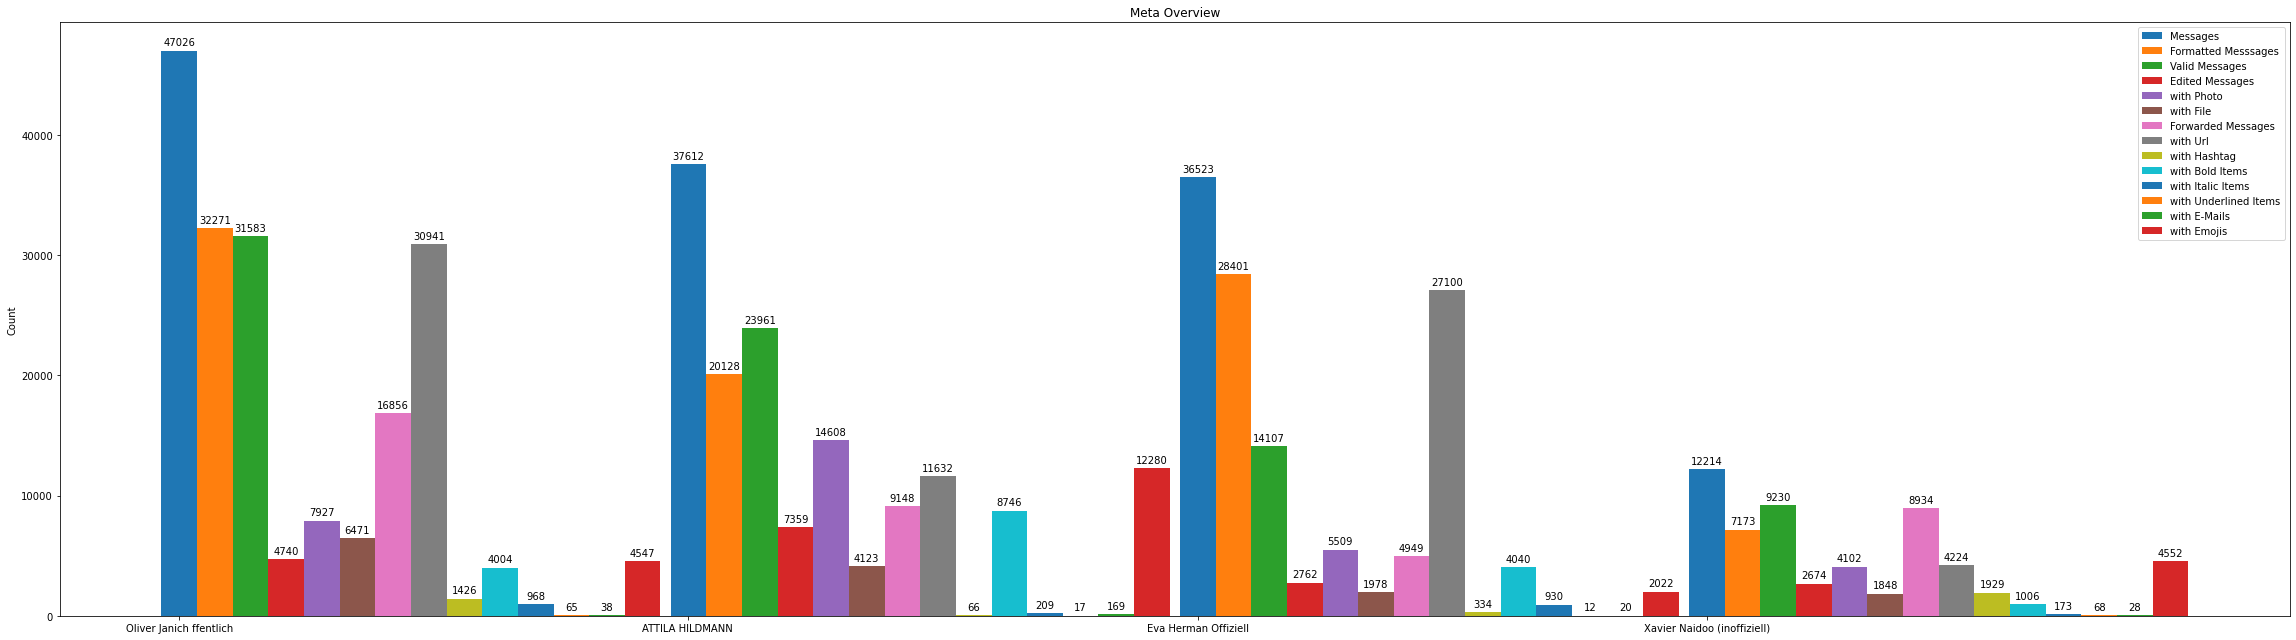

In [37]:
queryMetaPlotter(
    inputDescFilter = "dataSet0",
    configPlotWidth = 32,
    configPlotHeight = 9,
    configBarWidth = 0.07,
    outputFilename = "meta-overview-dataSet0.png"
)

In [38]:
if("dataSet1" in C_LOAD_DATASET):
    queryMetaPlotter(
        inputDescFilter = "dataSet1",
        configPlotWidth = 32,
        configPlotHeight = 9,
        configBarWidth = 0.07,
        outputFilename = "meta-overview-dataSet1.png"
    )

In [39]:
if("dataSet1a" in C_LOAD_DATASET):
    queryMetaPlotter(
        inputDescFilter = "dataSet1a",
        configPlotWidth = 16,
        configPlotHeight = 9,
        configBarWidth = 0.08,
        outputFilename = "meta-overview-dataSet1a.png"
    )

### Get text-length

In [40]:
def removeTextLengthOutliersFromDataFrame(df, interval, maxTextLength):
    df = df.copy()
    df = df[df.procTDTextLength < maxTextLength]
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within <interval> to -<interval> standard deviations in the column 'Data'.
    return df[np.abs(df.procTDTextLength-df.procTDTextLength.mean()) <= (interval*df.procTDTextLength.std())]

In [41]:
# param outputFilename set "" == no output file
def textLengthHistPlotter(outputFilename):
    dfMessages = dfAllDataMessages.copy()
    print("Number of all messages:\t\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = dfMessages[dfMessages.procEvalIsValidText == True]
    print("Number of valid text messages:\t\t\t\t\t" + str(len(dfMessages.index)))

    dfMessages = removeTextLengthOutliersFromDataFrame(
        dfMessages,
        interval = 3,               #Default is 3
        maxTextLength = 999999999   #TODO: Maybe enable max text length
        )
    print("Number of valid text messages (after outliers filtering):\t" + str(len(dfMessages.index)))

    print()
    print("Text Length Hist (after outliers filtering)")
    plt.figure(figsize=(8,4.5))
    _ = dfMessages.procTDTextLength.hist(bins=40)

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

Number of all messages:						133375
Number of valid text messages:					78881
Number of valid text messages (after outliers filtering):	77136

Text Length Hist (after outliers filtering)


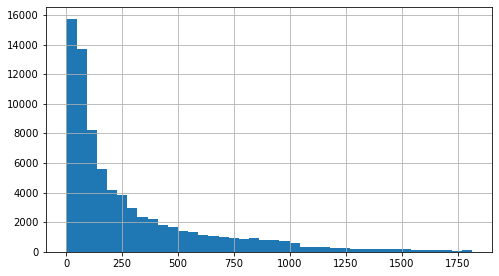

In [42]:
textLengthHistPlotter(outputFilename = "meta-text-length-hist.png")

### Compare ids and labels (has chat name changed?)

In [43]:
def compareIdsAndLabels(df):

    gloStartStopwatch("Compare ids and labels")

    dictFromTranslator  = {}
    dictActorTranslator = {}

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    df = df.set_index("date")
    df = df.sort_index()

    for index, row in df.iterrows():
        
        n_from      = row["from"]
        n_from_id   = row["from_id"]

        n_actor      = row["actor"]
        n_actor_id   = row["actor_id"]

        if(str(n_from) != "nan"):
            if(n_from_id not in dictFromTranslator):
                # Add new key
                #print("- Add from " + str(n_from_id) + "/" + str(n_from))
                dictFromTranslator[n_from_id] = n_from
            else:
                # Has changed?
                oValue = dictFromTranslator[n_from_id]
                if(oValue != n_from):
                    print("- Add changed attribute in from (prev=" + str(oValue) + "/new=" + str(n_from) + ")")
                    dictFromTranslator[n_from_id] = n_from

        if(str(n_actor) != "nan"):
            if(n_actor_id not in dictActorTranslator):
                # Add new key
                #print("- Add actor " + str(n_actor_id) + "/" + str(n_actor))
                dictActorTranslator[n_actor_id] = n_actor
            else:
                # Has changed?
                oValue = dictActorTranslator[n_actor_id]
                if(oValue != n_actor):
                    print("- Add changed attribute in actor (prev=" + str(oValue) + "/new=" + str(n_actor) + ")")
                    dictActorTranslator[n_actor_id] = n_actor

    gloStopStopwatch("Compare ids and labels")

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
if(FLAG_SHORT_RUN == False):
    compareIdsAndLabels(dfAllDataMessages)

[Stopwatch started >>Compare ids and labels<<]
[Stopwatch stopped >>Compare ids and labels<< (14.476s)]


## Extract Social Graph Data

In [45]:
def resolveUrl(completeUrl):
    
    if "bit.ly" in completeUrl:

        if(gloCheckIsAlreadyCached("resolved-urls.csv", completeUrl)):
            return gloGetCached("resolved-urls.csv", completeUrl)
        else:
            print("Resolve now >>" + completeUrl + "<<")
            try:
                r = requests.get(completeUrl, timeout = 5)
                u = r.url
                gloAddToCache("resolved-urls.csv", completeUrl, u)
                return u
            except:
                print("- Warn: Can not resolve (return completeUrl)")
                return completeUrl

    else:
        return completeUrl

In [46]:
# TODO: Extract hashtags in non formatted text

def extractImportantHashtags(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsHashtag == True]

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["procTDHashtags"]:
            hashTagList.append(hashtagItem)

    return hashTagList

In [47]:
# Return
# a = urlList,
# b = urlResolvedList
# c = refList
# d = hostList
def extractImportantUrls(df):
    dfMessages = df.copy()
    dfMessages = dfMessages[dfMessages.procEvalContainsUrl == True]

    hostList        = list()
    urList          = list()
    urlResolvedList = list()
    refList         = list()

    counterSucHostname = 0
    counterErrHostname = 0

    for index, row in dfMessages.iterrows():
        for urlItem in row["procTDURLs"]:
            
            urlData = urlparse(str(urlItem))

            completeUrl      = urlData.geturl()
            completeHostname = urlData.hostname

            if(str(completeHostname) != "None"):
                counterSucHostname = counterSucHostname + 1
                hostList.append(str(completeHostname))

                urList.append(str(completeUrl))
                urlResolvedList.append(str(resolveUrl(completeUrl)))

                if "t.me" in str(completeHostname):
                    refList.append(str(completeUrl))
            else:
                counterErrHostname = counterErrHostname + 1

    print("Got Hostnames (suc=" + str(counterSucHostname) + "/err=" + str(counterErrHostname) + ")")

    return (urList, urlResolvedList, refList, hostList)

In [48]:
# TODO: Bug: No Hostname detected if string startsWith ! "http" in urlparse
# TODO: Feature: Url in non formatted text?
# TODO: Feature: Add other attributes (e.g. hashtags)
# TODO: Feature: Cache-Layer: Check if both set (from and from_id, actor, ...)
# TODO: Check: Duplicates refs from text

# TODO: Doc: Text ref important for finding groups
# TODO: Doc: forwared_from important for graphs

# Returns
# a = Counter forwardedFromList
# b = Counter refList
# c = Counter hashtagList
# d = Counter hostList
def extractSocialGraph(filePath, debugPrint):

    dfMessages = dictMessages[filePath].copy()

    hashtagList = extractImportantHashtags(dfMessages)

    urlList, urlResolvedList, refList, hostList = extractImportantUrls(dfMessages)
            
    forwardedFromList = list()
    if("forwarded_from" in dfMessages.columns):
        df = dfMessages.copy()
        df = df[df.procEvalIsForwarded == True]
    
        for index, row in df.iterrows():        
            forwardedFromList.append(str(row["forwarded_from"]))
            
    actorList = list()
    if("actor" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            actorList.append(str(row["actor"]))
    
    memberList = list()
    if("members" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            if(str(row["members"]) != "nan"):
                for memberItem in row["members"]:
                    memberList.append(str(memberItem))
                    
    fromList = list()
    if("from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            fromList.append(str(row["from"]))
            
    savedFromList = list()
    if("saved_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            savedFromList.append(str(row["saved_from"]))

    configTopN = 5

    if(debugPrint):
        print("- Top Hosts -")
        print ("\n".join(map(str, Counter(hostList).most_common(configTopN))))
        print()
        print("- Top URLs -")
        print ("\n".join(map(str, Counter(urlList).most_common(configTopN))))
        print()
        print("- Top URLs resolved -")
        print ("\n".join(map(str, Counter(urlResolvedList).most_common(configTopN))))
        print()
        print("- Top Refs from text -")
        print ("\n".join(map(str, Counter(refList).most_common(configTopN))))
        print()
        print("- Top Refs (forwarded_from) -")
        print ("\n".join(map(str, Counter(forwardedFromList).most_common(configTopN))))
        print()
        print("- Top Refs (actor) -")
        print ("\n".join(map(str, Counter(actorList).most_common(configTopN))))
        print()
        print("- Top Refs (members) -")
        print ("\n".join(map(str, Counter(memberList).most_common(configTopN))))
        print()
        print("- Top Refs (from) -")
        print ("\n".join(map(str, Counter(fromList).most_common(configTopN))))
        print()
        print("- Top Refs (saved_from) -")
        print ("\n".join(map(str, Counter(savedFromList).most_common(configTopN))))
        print()
        print("- Top hashtags -")
        print ("\n".join(map(str, Counter(hashtagList).most_common(configTopN))))
        print()
    
    return (Counter(forwardedFromList), Counter(refList), Counter(hashtagList),  Counter(hostList))

In [49]:
dictSGD_ForwardedFrom = {}
dictSGD_Ref           = {}
dictSGD_Hashtag       = {}
dictSGD_Host          = {}

gloStartStopwatch("Extract Social Graph Data")

for fP in dfInputFiles.inputPath:

    gloStartStopwatch("Extract Social Graph Data >>" + fP + "<<")

    a, b, c, d = extractSocialGraph(fP, debugPrint=False)

    dictSGD_ForwardedFrom[fP]   = a
    dictSGD_Ref[fP]             = b
    dictSGD_Hashtag[fP]         = c
    dictSGD_Host[fP]            = d

    gloStopStopwatch("Extract Social Graph Data >>" + fP + "<<")

gloStopStopwatch("Extract Social Graph Data")

[Stopwatch started >>Extract Social Graph Data<<]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
Got Hostnames (suc=12751/err=441)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (10.017s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
Resolve now >>https://bit.ly/3joBCF7<<
- Warn: Can not resolve (return completeUrl)
Got Hostnames (suc=36363/err=630)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (19.694s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
Got Hostnames (suc=27741/err=229)
[Stopwatch stopped >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (10.121s)]
[Stopwatch started >>Extract Social Graph Data >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
Resolve now >>https://bit.ly/2ydhZOo<<
- Warn

In [50]:
def printSocialGraphDebug(filePathList):
    for fP in filePathList:
        print("Analyse now >>" + fP + "<<")
        _ = extractSocialGraph(fP, debugPrint=True)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
if(FLAG_SHORT_RUN == False):
    printSocialGraphDebug(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
Got Hostnames (suc=12751/err=441)
- Top Hosts -
('youtu.be', 3225)
('t.me', 902)
('www.youtube.com', 578)
('www.n-tv.de', 315)
('www.bitchute.com', 279)

- Top URLs -
('https://bit.ly/37OCsH5', 105)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 69)
('https://demo.terminkalender.top/pc.php', 60)
('https://demos.whattheyhide.org/add', 46)
('https://youtu.be/kWpzfqW34lA', 41)

- Top URLs resolved -
('https://www.attilahildmann.de/de/shop/alle.html?pc=SAMURAI', 106)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 69)
('https://demo.terminkalender.top/pc.php', 60)
('https://demos.whattheyhide.org/add', 46)
('https://youtu.be/kWpzfqW34lA', 41)

- Top Refs from text -
('https://t.me/ATTILAHILDMANN', 34)
('https://t.me/gerechtigkeitfuersvaterland', 27)
('https://t.me/FreiheitsChatDE', 27)
('https://t.me/NachrichtenWelt', 27)
('https://t.me/FREIHEITS_CHAT_BL', 23)

- Top Refs (forwarded_from) -
('ATTILA HILDMANN ⚫️⚪️🔴⚔️', 7448)
('

### Get Top Influencer (Downloaded?)

In [52]:
# Get Top Influencer
# param fPList      filePath List
# param configTopN  Get Top n influencer e.g. 10
def getTopInfluencer(fPList, configTopN):

    for fP in fPList:

        chatName = queryChatName(fP)

        print()
        print("Analyse Chat (Forwarded From) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_ForwardedFrom[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # Already downloaded?
            flagDownloaded = False
            if oChatName in dfQueryMeta.qryChatName.values:
                flagDownloaded = True

            if(oChatName != "nan"):

                print(str(counter) + ": (downloaded=" + str(flagDownloaded) + ") (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1


        print()
        print("Analyse Chat (Refs) >>" + chatName + "<<")
        
        socialGraphData = dictSGD_Ref[fP]
        socialGraphData = socialGraphData.most_common(configTopN)

        counter = 1

        # Iterate over data
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = str(oChatName)
            oChatRefs    = oChatRefs

            if(oChatName != "nan"):

                print(str(counter) + " (refs=" + str(oChatRefs) + ")\t\t>>" + str(oChatName) + "<<")
                counter = counter + 1

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [53]:
# TODO: Can not get all items in dataSet1

"""
# Attila Hildmann #
- Anonymous Germany - not found
- https://t.me/DEMOKRATENCHAT - no entries
- https://t.me/ChatDerFreiheit - no entries
- https://t.me/FREIHEITSCHAT2020 - not found

# Oliver Janich #
- Oliver Janich Premium - not found

# Xavier Naidoo #
- Xavier(Der VereiNiger)Naidoo😎 - not found
- https://t.me/PostAppender_bot - bot chat
"""
getTopInfluencer(list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath), 10)


Analyse Chat (Forwarded From) >>ATTILA HILDMANN <<
1: (downloaded=True) (refs=7448)		>>ATTILA HILDMANN <<
2: (downloaded=False) (refs=616)		>>Gerechtigkeit fr das Vaterland<<
3: (downloaded=False) (refs=44)		>>Aktuelle Karikaturen - Gtz Wie<<
4: (downloaded=False) (refs=41)		>>.   <<
5: (downloaded=False) (refs=38)		>>Anonymous Germany<<
6: (downloaded=False) (refs=34)		>>MICHAEL WENDLER <<
7: (downloaded=True) (refs=33)		>>Oliver Janich ffentlich<<
8: (downloaded=False) (refs=28)		>>Laser Lurch<<
9: (downloaded=False) (refs=28)		>>Dawid Snowden<<
10: (downloaded=False) (refs=26)		>>Ken Jebsen - Aufklrung und Inf<<

Analyse Chat (Refs) >>ATTILA HILDMANN <<
1 (refs=34)		>>https://t.me/ATTILAHILDMANN<<
2 (refs=27)		>>https://t.me/gerechtigkeitfuersvaterland<<
3 (refs=27)		>>https://t.me/FreiheitsChatDE<<
4 (refs=27)		>>https://t.me/NachrichtenWelt<<
5 (refs=23)		>>https://t.me/FREIHEITS_CHAT_BL<<
6 (refs=21)		>>https://t.me/DEMOKRATENCHAT<<
7 (refs=20)		>>https://t.me/ChatDerFreiheit<<


### Plot Social Graph

In [54]:
"""
Social Graph Layout Selector

param G Graph
param layoutSelector:

1 = Kamda Kawai Layout
2 = Spring Layout
3 = Graphviz Layout
"""
def getSocialGraphLayout(layoutSelector, G):
    switcher = {
        1: nx.kamada_kawai_layout(G.to_undirected()),
        2: nx.spring_layout(G.to_undirected(), k = 0.15, iterations=200),
        3: nx.nx_pydot.graphviz_layout(G)
    }
    return switcher.get(layoutSelector, None)

In [55]:
# TODO: Test different layouts: https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
# TODO: Try different arrows (see below): https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.ArrowStyle.html
# TODO: Check distances between nodes

"""
Draw social grah

param   G                           graph
param   layoutSelector              see above
param   configFactorEdge            e.g. 100 => weight / 100
param   configFactorNode            e.g. 10  => weight / 10
param   configArrowSize             e.g. 5
param   configPlotWidth             e.g. 16
param   configPlotHeight            e.g. 9
param   outputFilename              e.g. test.png (set "" == no output file)
"""
def drawSocialGraph(G, layoutSelector, configFactorEdge, configFactorNode, configArrowSize, configPlotWidth, configPlotHeight, outputFilename):
    
    gloStartStopwatch("Social Graph Plot")
    
    plt.figure(figsize=(configPlotWidth,configPlotHeight))
        
    pos = getSocialGraphLayout(layoutSelector = layoutSelector, G = G)
    
    # Clean edges
    edges       = nx.get_edge_attributes(G, "weight")
    edgesTLabel = nx.get_edge_attributes(G, "tLabel")

    clean_edges         = dict()
    clean_edges_labels  = dict()
    
    for key in edges:
        
        #Set edge weight
        clean_edges[key]        = (100 - edges[key]) / configFactorEdge

        #set edge layout
        clean_edges_labels[key] = edgesTLabel[key]
    
    # Clean nodes
    nodes       = nx.get_node_attributes(G,'weight')
    nodesTLabel = nx.get_node_attributes(G,'tLabel')
    nodesTColor = nx.get_node_attributes(G,'tColor')

    clean_nodes         = dict()
    clean_nodes_labels  = dict()
    clean_nodes_color   = dict()
    
    for key in nodes:
        
        #Set node weight        
        clean_nodes[key]        = nodes[key] / configFactorNode

        #Set node layout
        clean_nodes_labels[key] = nodesTLabel[key]
        clean_nodes_color[key]  = nodesTColor[key]
    
    # Revert DiGraph (arrows direction)
    G_rev = nx.DiGraph.reverse(G)    

    # Draw
    nx.draw(G_rev,
        pos,
        with_labels=True,
        width=list(clean_edges.values()),
        node_size=list(clean_nodes.values()),
        labels=clean_nodes_labels,
        node_color=list(clean_nodes_color.values()),
        arrowsize=configArrowSize,
        arrowstyle="wedge"
        #connectionstyle="arc3, rad = 0.1"
    )
    
    # Set labels
    _ = nx.draw_networkx_edge_labels(G_rev, pos, edge_labels=clean_edges_labels)

    # Save and show fig
    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)
    
    plt.show()
    
    gloStopStopwatch("Social Graph Plot")

In [56]:
# Generates Test Graph
def generateTestGraph():

    G_weighted = nx.DiGraph()

    G_weighted.add_edge("N1", "N2", weight=100-30,  tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N1", "N3", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")
    G_weighted.add_edge("N1", "N4", weight=100-60,  tLabel = "(≙" + str(100-60) + ")")

    G_weighted.add_edge("N4", "N5", weight=100-80,  tLabel = "(≙" + str(100-80) + ")")
    G_weighted.add_edge("N4", "N6", weight=100-10,  tLabel = "(≙" + str(100-10) + ")")

    G_weighted.add_edge("N4", "N7", weight=100-30,   tLabel = "(≙" + str(100-30) + ")")
    G_weighted.add_edge("N7", "N4", weight=100-70,   tLabel = "(≙" + str(100-70) + ")")

    G_weighted.add_node("N1", weight=500.0, tLabel = "N1-T", tColor="red")
    G_weighted.add_node("N2", weight=500.0, tLabel = "N2-T", tColor="blue")
    G_weighted.add_node("N3", weight=500.0, tLabel = "N3-T", tColor="blue")
    G_weighted.add_node("N4", weight=500.0, tLabel = "N4-T", tColor="red")
    G_weighted.add_node("N5", weight=500.0, tLabel = "N5-T", tColor="red")
    G_weighted.add_node("N6", weight=500.0, tLabel = "N6-T", tColor="red")
    G_weighted.add_node("N7", weight=500.0, tLabel = "N7-T", tColor="blue")

    return G_weighted

In [57]:
# Add node weight to dict
# Only adds new weight if newWeight > oldWeight
def addSocialGraphNodeWeight(chatName, chatWeight, targetDict):
    
    if(chatName in targetDict):
        oldWeight = targetDict[chatName]
        if(chatWeight > oldWeight):
            targetDict[chatName] = chatWeight
    else:
        targetDict[chatName] = chatWeight

In [58]:
"""
Generate social graph

param   configTopNInfluencer        e.g. For top 10 = 10
param   configMinRefs               e.g. 1 must have > 1 % forwarded messages
param   listFilePaths               List process filePaths
param   socialGraphTargetDict       e.g. forwarded from dict or hashtag dict
param   socialGraphTargetAttribute  e.g. procEvalIsForwarded (for calc percent)
param   configFlagDebugLabel        e.g. show debug info on label
"""
def generateSocialGraph(configTopNInfluencer, configMinRefs, listFilePaths, socialGraphTargetDict, socialGraphTargetAttribute, configFlagDebugLabel):
    
    # Save node weights to dict
    dictSocialNodeWeights   = dict()

    # Flag downloaded nodes (exact node weight)
    dictExactNodesLabels    = {}
    
    gloStartStopwatch("Social Graph")
    
    # Generate directed graph
    G_weighted = nx.DiGraph()
    
    print("- Add edges")
    for fP in listFilePaths:
        
        # Query own params
        chatName                        = queryChatName(fP)
        chatNumberOfMessages            = queryNumberOfMessages(fP)
        chatNumberOfTargetMessages      = queryNumberOfMessagesByAttEqTrue(fP, socialGraphTargetAttribute)

        gloStartStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
        # Add exact node size (chat downloaded) and flag node
        addSocialGraphNodeWeight(chatName, chatNumberOfMessages, dictSocialNodeWeights)
        dictExactNodesLabels[chatName] = str(chatName) + "\n=[" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + "]"

        # Extract social graph data and get top influencer
        socialGraphData = socialGraphTargetDict[fP]
        socialGraphData = socialGraphData.most_common(configTopNInfluencer)
        
        # Iterate over forwarder
        for oChatName, oChatRefs in socialGraphData:
            
            # Query other params
            oChatName    = gloConvertToSafeChatName(str(oChatName))
            oChatRefs    = oChatRefs

            # If has forwarder
            if(oChatName != "nan"):
        
                # Calc percent (forwarded_messages)
                per = (oChatRefs/chatNumberOfTargetMessages) * 100

                # Filter unimportant forwarders
                if(per > configMinRefs):
                
                    # Add estimanted node size (chat not downloaded)
                    addSocialGraphNodeWeight(oChatName, oChatRefs, dictSocialNodeWeights)

                    # Invert percent (distance)
                    wei = 100 - per

                    # Label
                    if(configFlagDebugLabel):
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + "≙" + str(round(wei, 3)) + ")"
                    else:
                        lab = str(round(per, 3)) + "% (" + str(oChatRefs) + "/" + str(chatNumberOfTargetMessages) + ")"

                    # Add edge
                    G_weighted.add_edge(
                        chatName,
                        oChatName,
                        weight=wei,
                        tLabel = lab
                    )

        gloStopStopwatch("SG-Extract " + chatName + "(" + str(chatNumberOfTargetMessages) + "/" + str(chatNumberOfMessages) + " messages)")
        
    print("- Add different nodes")
    for aNode in dictSocialNodeWeights:
        
        # Query node params
        nodeName   = str(aNode)
        nodeWeight = dictSocialNodeWeights[aNode]

        # Set defaults
        tValueColor = "#ff8000"
        tLabel = str(nodeName) + "\n≈[" + str(nodeWeight) + "]"

        # Overwrite (if chat downloaded = exact weight)
        if(nodeName in dictExactNodesLabels):
            tValueColor = "#0080ff"
            tLabel = dictExactNodesLabels[nodeName]
        
        G_weighted.add_node(
            nodeName,
            weight=nodeWeight,
            tLabel = tLabel,
            tColor=tValueColor
        )
        
    gloStopStopwatch("Social Graph")
        
    return G_weighted

#### Test Graphs

In [59]:
generatedTestGraph = generateTestGraph()

[Stopwatch started >>Social Graph Plot<<]


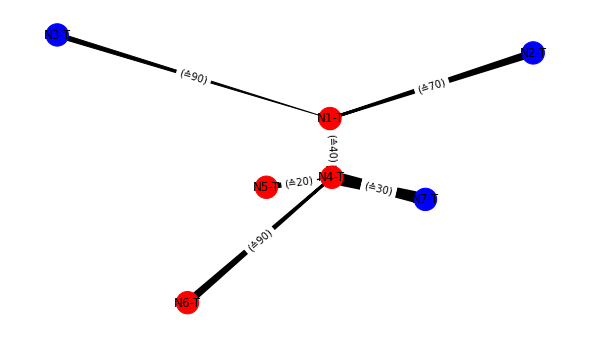

[Stopwatch stopped >>Social Graph Plot<< (1.310s)]


In [60]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=1,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = ""
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Social Graph Plot<<]


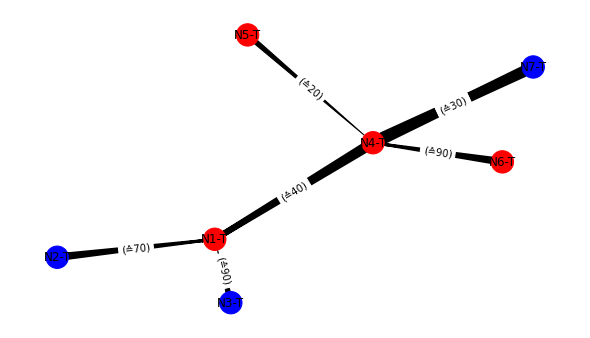

[Stopwatch stopped >>Social Graph Plot<< (0.343s)]


In [61]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=2,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = ""
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Social Graph Plot<<]


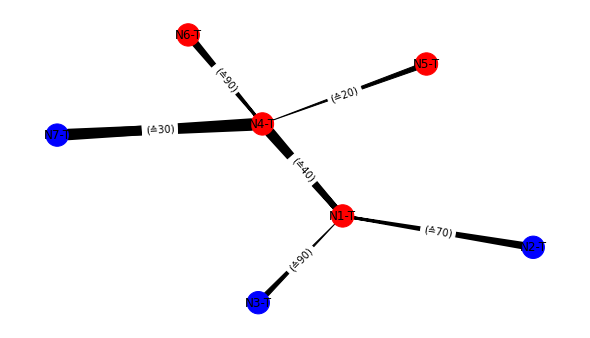

[Stopwatch stopped >>Social Graph Plot<< (0.338s)]


In [62]:
drawSocialGraph(
    G = generatedTestGraph,
    layoutSelector=3,
    configFactorEdge = 10,
    configFactorNode = 1,
    configArrowSize = 15,
    configPlotWidth = 8,
    configPlotHeight = 4.5,
    outputFilename = ""
)

#### Real Graph (ForwardedFrom)

In [63]:
generatedSocialGraphForwardedFrom = generateSocialGraph(
    configTopNInfluencer = 25,  
    configMinRefs = 0,       
    listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
    socialGraphTargetDict = dictSGD_ForwardedFrom,
    socialGraphTargetAttribute = "procEvalIsForwarded",
    configFlagDebugLabel = False
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (9148/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (9148/37612 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Oliver Janich ffentlich(16856/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich ffentlich(16856/47026 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(4949/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(4949/36523 messages)<< (0.000s)]
[Stopwatch started >>SG-Extract Xavier Naidoo (inoffiziell)(8934/12214 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo (inoffiziell)(8934/12214 messages)<< (0.001s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.443s)]


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Social Graph Plot<<]


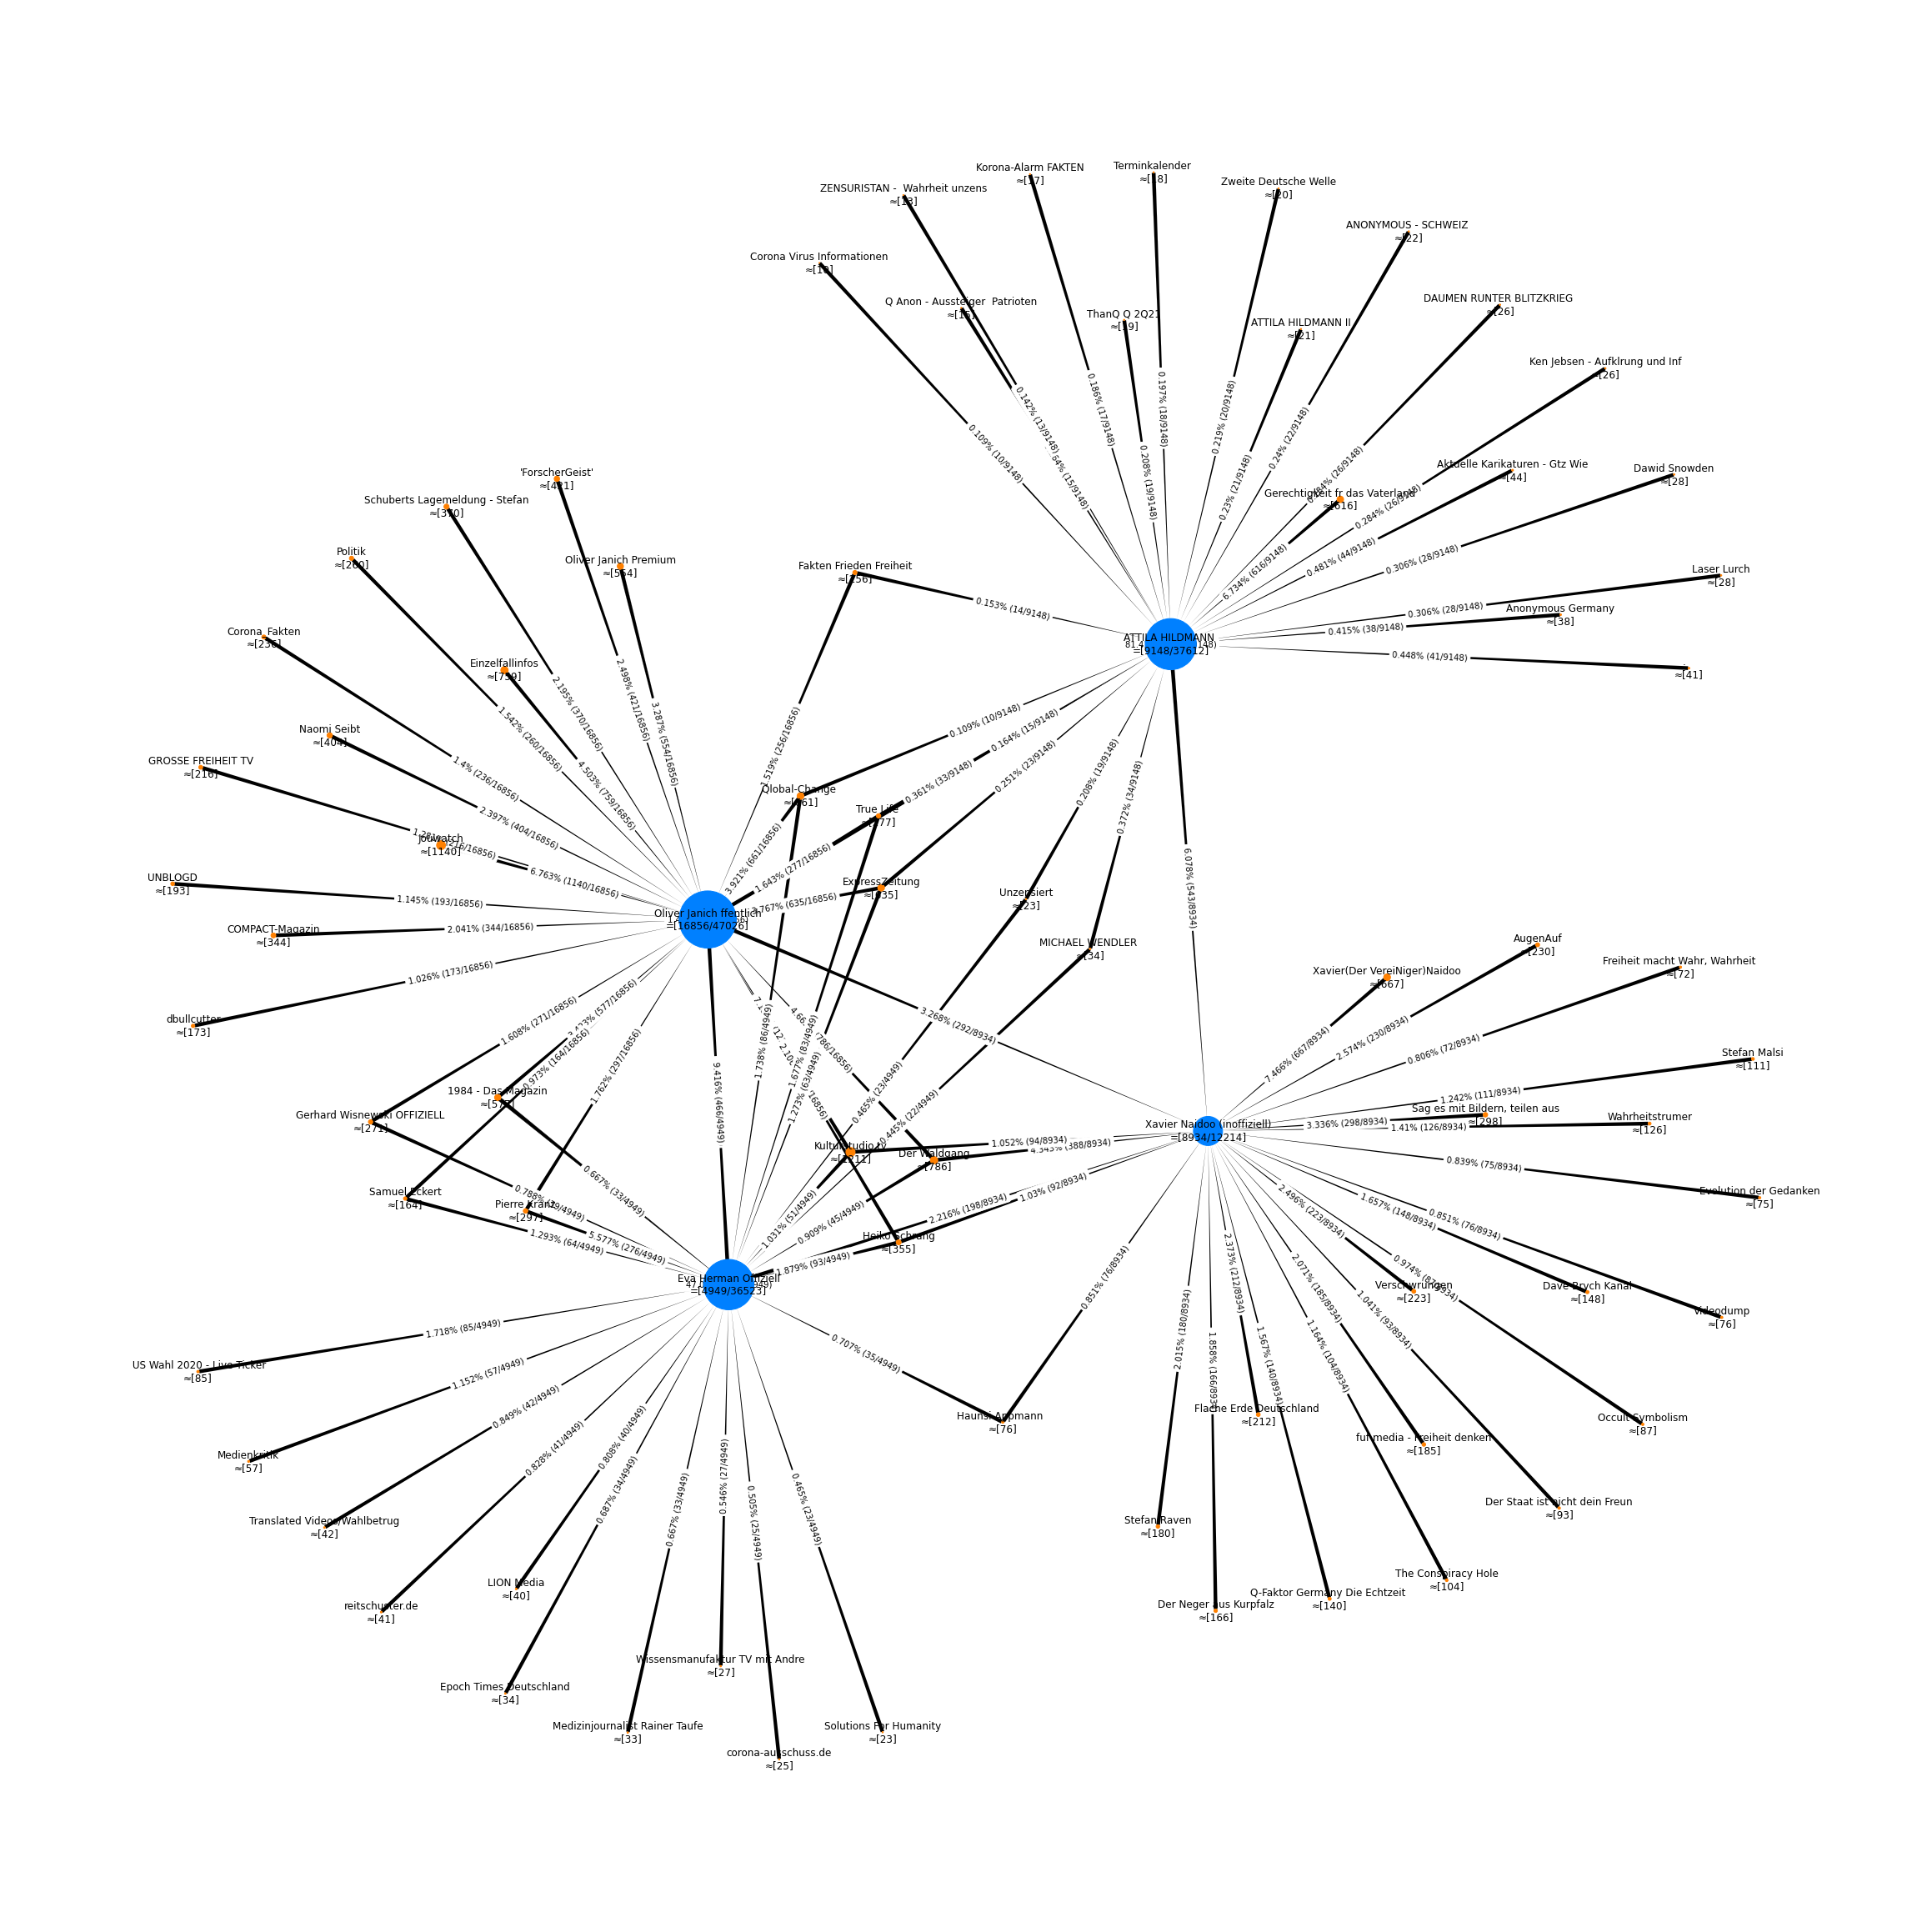

[Stopwatch stopped >>Social Graph Plot<< (5.266s)]


In [64]:
drawSocialGraph(
    generatedSocialGraphForwardedFrom,
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-forwarded-from.png"
)

#### Real Graph (Hashtag)

In [65]:
generatedSocialGraphHashtag = generateSocialGraph(
    configTopNInfluencer = 30,  
    configMinRefs = 0,        
    listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
    socialGraphTargetDict = dictSGD_Hashtag,
    socialGraphTargetAttribute = "procEvalContainsHashtag",
    configFlagDebugLabel = False
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (66/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (66/37612 messages)<< (0.000s)]
[Stopwatch started >>SG-Extract Oliver Janich ffentlich(1426/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich ffentlich(1426/47026 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(334/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(334/36523 messages)<< (0.000s)]
[Stopwatch started >>SG-Extract Xavier Naidoo (inoffiziell)(1929/12214 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo (inoffiziell)(1929/12214 messages)<< (0.000s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.421s)]


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Social Graph Plot<<]


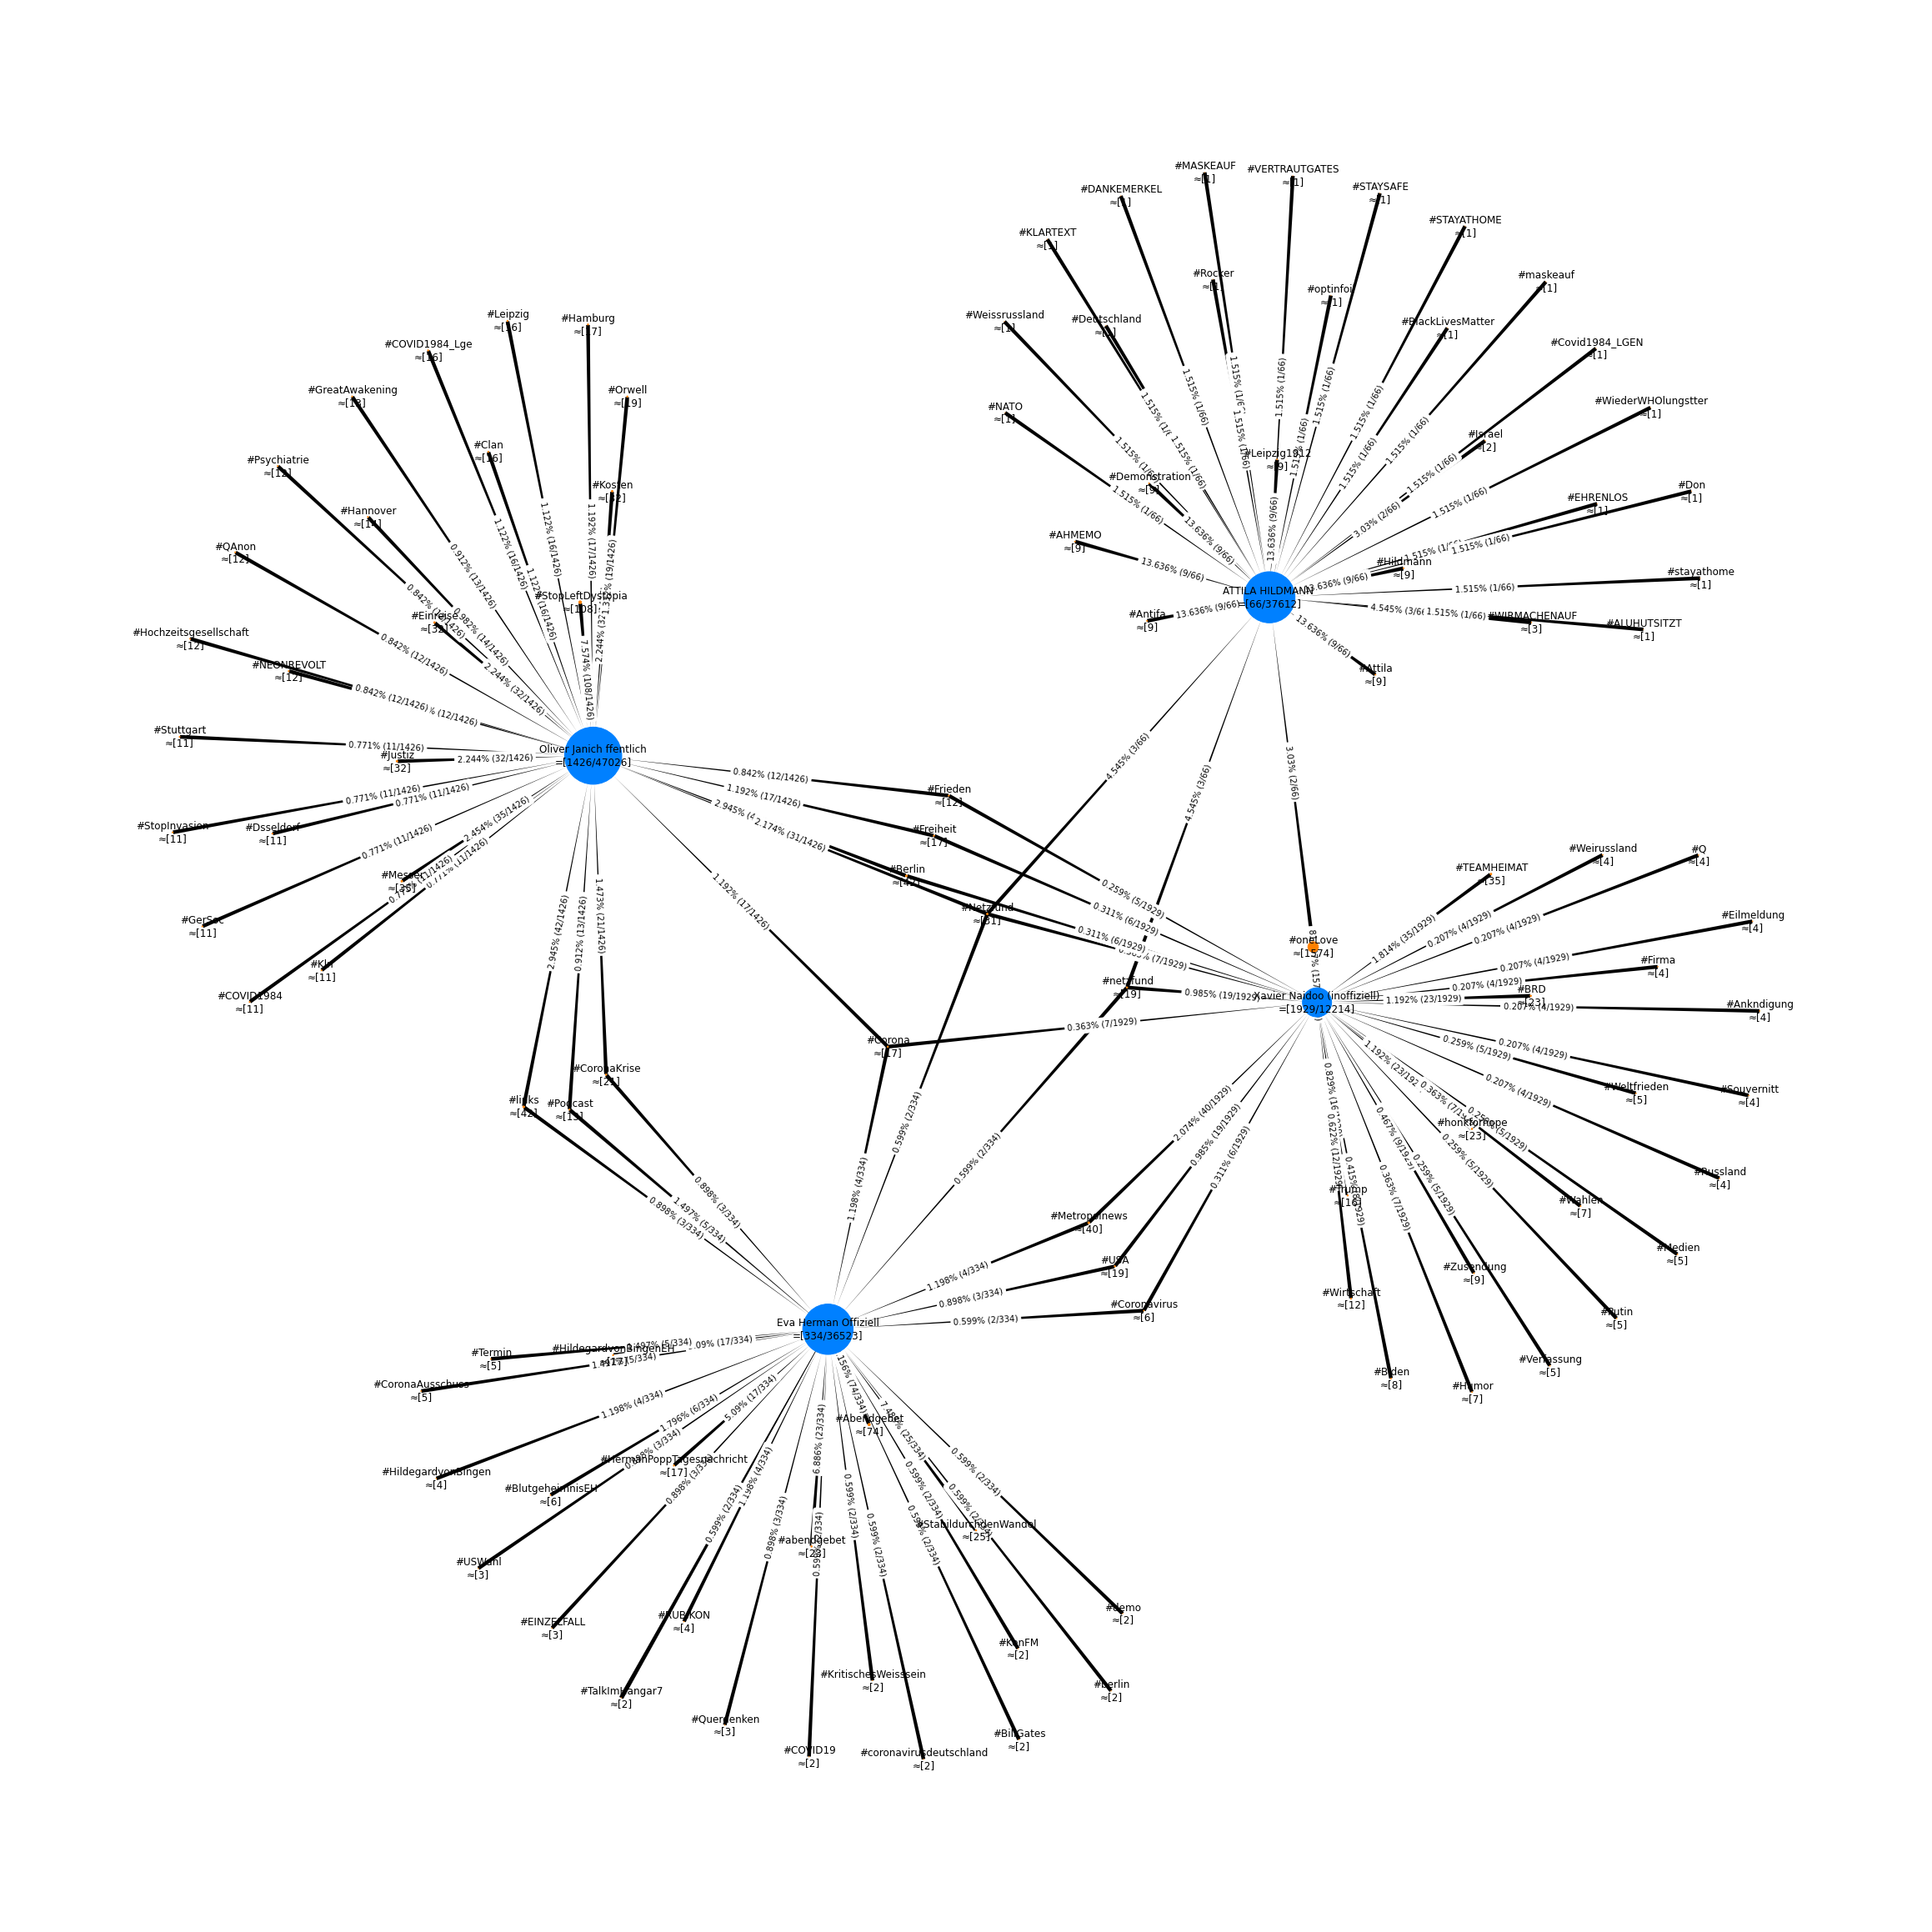

[Stopwatch stopped >>Social Graph Plot<< (6.966s)]


In [66]:
drawSocialGraph(
    generatedSocialGraphHashtag,
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-hashtag.png"
)

#### Real Graph (Hosts)

In [67]:
generatedSocialGraphHost = generateSocialGraph(
    configTopNInfluencer = 25,  
    configMinRefs = 0,        
    listFilePaths = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
    socialGraphTargetDict = dictSGD_Host,
    socialGraphTargetAttribute = "procEvalContainsUrl",
    configFlagDebugLabel = False
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Social Graph<<]
- Add edges
[Stopwatch started >>SG-Extract ATTILA HILDMANN (11632/37612 messages)<<]
[Stopwatch stopped >>SG-Extract ATTILA HILDMANN (11632/37612 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Oliver Janich ffentlich(30941/47026 messages)<<]
[Stopwatch stopped >>SG-Extract Oliver Janich ffentlich(30941/47026 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Eva Herman Offiziell(27100/36523 messages)<<]
[Stopwatch stopped >>SG-Extract Eva Herman Offiziell(27100/36523 messages)<< (0.001s)]
[Stopwatch started >>SG-Extract Xavier Naidoo (inoffiziell)(4224/12214 messages)<<]
[Stopwatch stopped >>SG-Extract Xavier Naidoo (inoffiziell)(4224/12214 messages)<< (0.001s)]
- Add different nodes
[Stopwatch stopped >>Social Graph<< (0.436s)]


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Social Graph Plot<<]


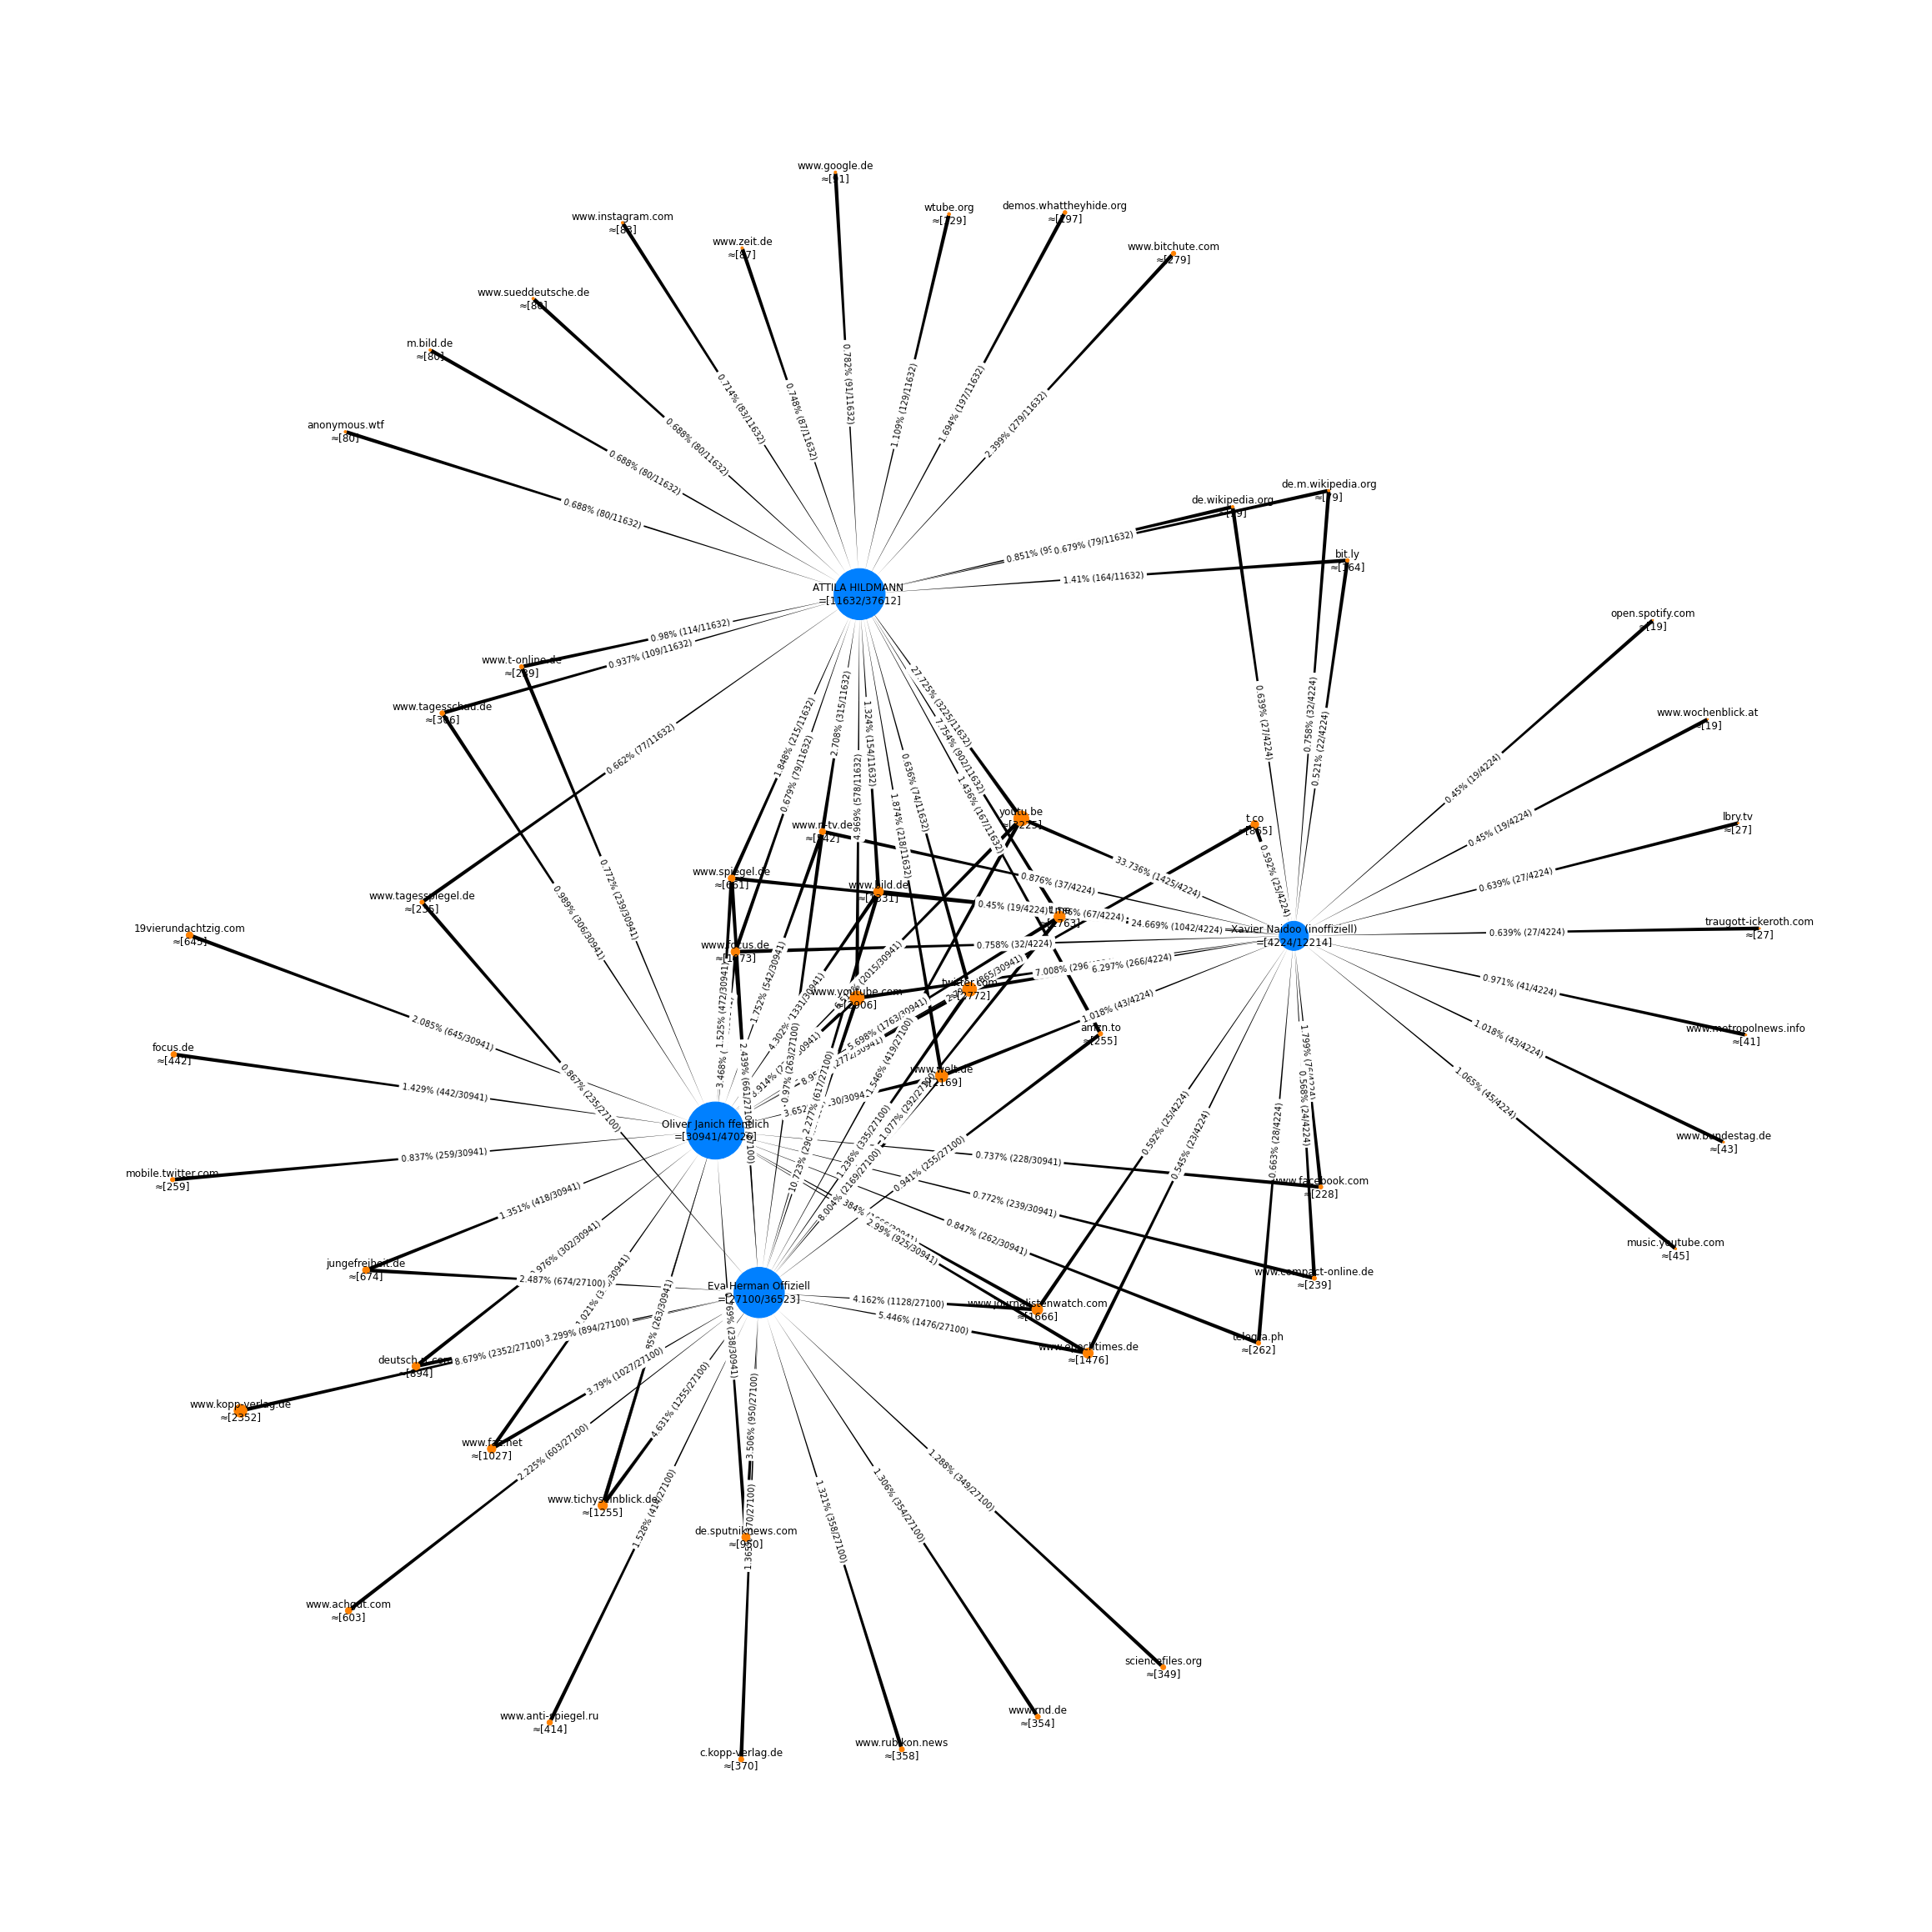

[Stopwatch stopped >>Social Graph Plot<< (4.803s)]


In [68]:
drawSocialGraph(
    generatedSocialGraphHost,
    layoutSelector = 1,
    configFactorEdge = 100,
    configFactorNode = 10,
    configArrowSize = 15,
    configPlotWidth = 32,
    configPlotHeight = 32,
    outputFilename = "social-graph-dataSet0-host.png"
)

## Time Tools

In [69]:
"""
param   targetDate      e.g. 1970-01-01
param   fP              filePath
param   highlightWord   set "" = no filter
"""
def queryNumberOfMessagesByDate(targetDate, fP, highlightWord):

    df = dictMessages[fP].copy()

    df = df[df.procEvalIsValidText == True]

    df["date"] = pd.to_datetime(df["date"])
    
    df = df[df.date <= targetDate]

    if(highlightWord != ""):
        df = df[df.procTDCleanText.str.contains(highlightWord)]

    l = len(df.index)

    if(l > 0):
        return l
    else:
        return np.nan

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
"""
param   filePathList
param   outputFilename  set "" = no output file
param   highlightWords  list of highlight words (leave empty if not used)
"""
def drawTimePlot(filePathList, outputFilename, highlightWords):

    gloStartStopwatch("Time Plot")

    # Set plot style
    plt.style.use('ggplot')
    plt.figure(figsize=(16, 9))

    df = pd.DataFrame(
        index=pd.date_range( #m/d/y
            start='9/1/2018',
            end='2/1/2021',
            freq="1D"
            )
        )

    # Add date to process
    df["date"] = df.index

    vLineHeight = -1

    for fP in filePathList:
        gloStartStopwatch("Time Plot >>" + fP + "<<")

        # Set vline height
        currentHeight = queryNumberOfMessagesByAttEqTrue(fP, "procEvalIsValidText")
        if(currentHeight > vLineHeight):
            vLineHeight = currentHeight

        # Plot
        plt.plot(
            df.index, #x
            df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = ""), axis=1), #y
            label = queryChatName(fP) #label
        )

        # Plot High Light Word Graph
        for hWord in highlightWords:
            plt.plot(
                df.index, #x
                df.apply(lambda x: queryNumberOfMessagesByDate(x.date, fP, highlightWord = hWord), axis=1), #y
                label = queryChatName(fP) + " usage of '" + hWord + "'" #label
            ) 

        gloStopStopwatch("Time Plot >>" + fP + "<<")

    # yy - mm - dd
    # TODO: Double check https://www.bundesgesundheitsministerium.de/coronavirus/chronik-coronavirus.html?stand=20210104
    plt.vlines(x = ["2020-01-27"], ymin=0, ymax=vLineHeight, color="grey", ls='--', label="Corona Patient Zero Germany")
    plt.vlines(x = ["2020-03-23"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="1. Lockdown Germany (2020-03-23)")
    plt.vlines(x = ["2020-11-02"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="2. Lockdown light Germany (2020-11-02)")
    plt.vlines(x = ["2020-12-16"], ymin=0, ymax=vLineHeight, color="purple", ls='--', label="3. Lockdown Germany (2020-12-16)")

    _ = plt.legend()

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

    gloStopStopwatch("Time Plot")

[Stopwatch started >>Time Plot<<]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<< (91.054s)]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (118.371s)]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<< (71.558s)]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<< (35.143s)]
[Stopwatch stopped >>Time Plot<< (316.438s)]


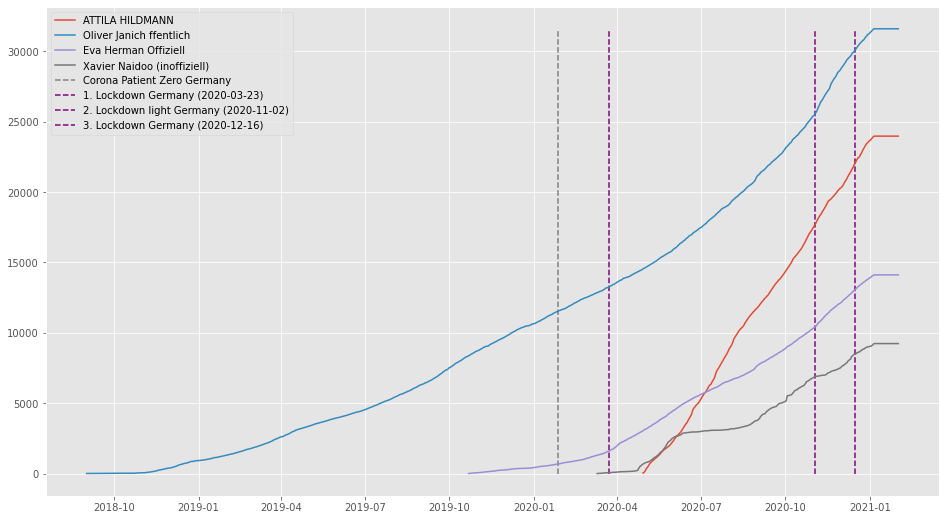

In [71]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath),
        outputFilename = "time-plot-dataSet0.png",
        highlightWords = []
    )

In [72]:
if(FLAG_SHORT_RUN == False):
    if("dataSet1" in C_LOAD_DATASET):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1"].inputPath),
            outputFilename = "time-plot-dataSet1.png",
            highlightWords = []
        )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
if(FLAG_SHORT_RUN == False):
    if("dataSet1a" in C_LOAD_DATASET):
        drawTimePlot(
            filePathList = list(dfInputFiles[dfInputFiles.inputDesc == "dataSet1a"].inputPath),
            outputFilename = "time-plot-dataSet1a.png",
            highlightWords = []
        )

## Word Clouds

In [74]:
def getStopWordsList(filterList):

    stopwWorldsList = nltk.corpus.stopwords.words('german')

    for s in nltk.corpus.stopwords.words('english'):
        stopwWorldsList.append(s)

    return stopwWorldsList

In [75]:
# TODO: Improve cleaning
def generateTextFromChat(df):
    df = df.copy()
    df = df[df.procEvalIsValidText == True]
    
    # Iterate over text (global text from group)
    textList = []
    for index, row in df.iterrows():
        textList.append(" " + row["procTDSafeText"])
        
    textString = ''.join(textList)

    return textString

In [76]:
# TODO: Difference capital letters?
# TODO: Context?
# TODO: Improve stop words
# TODO: Only on valid text?

"""
WordCloud

param   targetDataFrame     DataFrame
param   outputFilename      filename in outputdir (set "" == no output file)
param   filterList          Exclude list
param   flagShow            Set true == show wordcloud
param   configPlotWidth     e.g. 1920
param   configPlotHeight    e.g. 1080
"""
def generateWordCloud(targetDataFrame, outputFilename, filterList, flagShow, configPlotWidth, configPlotHeight):
    
    gloStartStopwatch("Word Cloud")

    dfMessages = targetDataFrame.copy()
    
    print("- Start transform text to global text string")
    textString = generateTextFromChat(dfMessages)
    
    stopWordsList = getStopWordsList(filterList)
    
    # Generate word cloud and save it to file
    print("- Start generate cloud")
    wordcloud = WordCloud(
                background_color="black",
                width=configPlotWidth,
                height=configPlotHeight,
                stopwords=stopWordsList
            ).generate(textString)

    if(outputFilename != ""):
        wordcloud.to_file(dir_var_output + outputFilename)
    
    if(flagShow):
        # Show top 20
        print()
        print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
        print()
        
        # Show word cloud
        print("- Start generate figure")
        plt.figure(figsize=(14, 14))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.show()
    
    gloStopStopwatch("Word Cloud")

### Single Mode

[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud

Top 20 occ:
f r            1.000000
ber            0.341621
mehr           0.285764
wurde          0.243215
Deutschland    0.217913
sei            0.198039
Menschen       0.174838
Video          0.173437
sagte          0.170898
gibt           0.161180
k nnen         0.158203
schon          0.153826
Polizei        0.133689
immer          0.131150
wurden         0.130625
Trump          0.130275
geht           0.128699
bereit         0.126160
Corona         0.118631
ssen           0.113203
dtype: float64

- Start generate figure


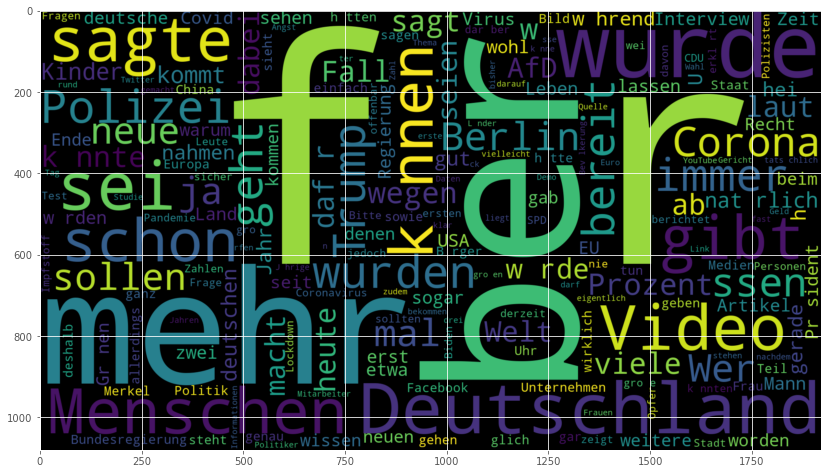

[Stopwatch stopped >>Word Cloud<< (16.677s)]


In [77]:
# Oliver Janich öffentlich (public_channel - dataSet0)
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
        "wordcloud-oliver-janich.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud

Top 20 occ:
f r                      1.000000
Folgen ATTILAHILDMANN    0.422974
Deutschland              0.353231
Wolf ATTILAHILDMANN      0.350359
Folg                     0.287795
ber                      0.274462
Menschen                 0.231795
mehr                     0.227282
Merkel                   0.212103
schon                    0.192615
Corona                   0.190974
mal                      0.183590
NWO                      0.175590
immer                    0.169641
wurde                    0.168000
k nnen                   0.161231
heute                    0.151795
gibt                     0.147897
macht                    0.147692
Deutschen                0.147282
dtype: float64

- Start generate figure


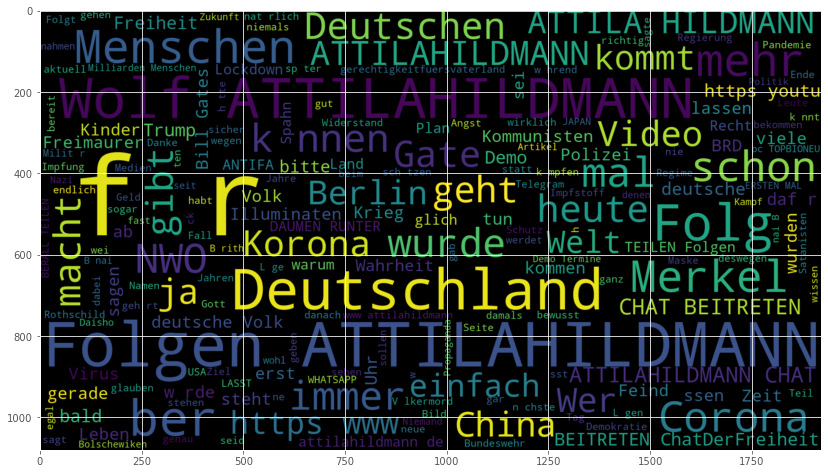

[Stopwatch stopped >>Word Cloud<< (10.281s)]


In [78]:
# ATTILA HILDMANN OFFICIAL (public_channel - dataSet0)
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
        "wordcloud-attila-hildmann.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud

Top 20 occ:
f r            1.000000
ber            0.339654
mehr           0.246746
Menschen       0.213532
wurde          0.191427
k nnen         0.181777
Deutschland    0.152940
immer          0.146207
heute          0.141719
Corona         0.141607
gibt           0.139250
sagte          0.119614
Welt           0.112320
schon          0.109627
ssen           0.106149
geht           0.102671
sei            0.101324
viele          0.099080
bereit         0.099080
Zeit           0.098631
dtype: float64

- Start generate figure


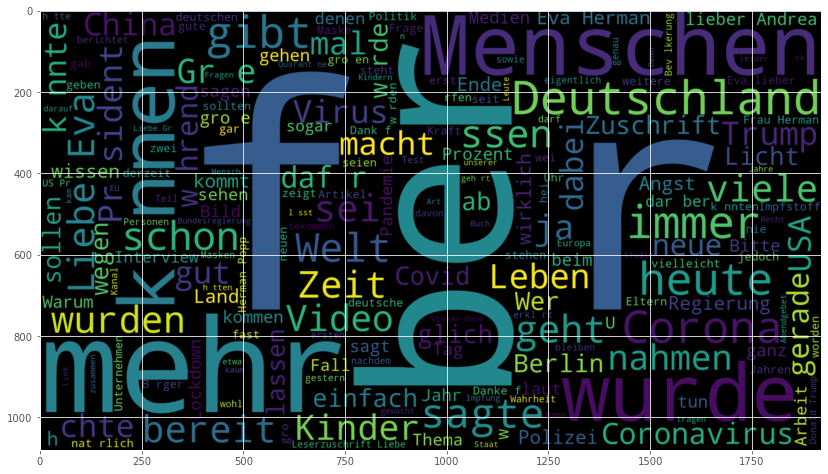

[Stopwatch stopped >>Word Cloud<< (11.567s)]


In [79]:
# Eva Herman Offiziell (public_channel - dataSet0)
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
        "wordcloud-eva-herman.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud

Top 20 occ:
Xavier Naidoo     1.000000
f r               0.815342
oneLove Xavier    0.566470
naidoo OneLove    0.436654
ber               0.299896
mehr              0.265880
Menschen          0.240194
wurde             0.195765
gibt              0.176675
schon             0.173898
Wer               0.163138
immer             0.162096
Video             0.160014
k nnen            0.154807
Deutschland       0.154460
mal               0.151336
Wahrheit          0.140576
Corona            0.137799
Liebe             0.131552
ja                0.127386
dtype: float64

- Start generate figure


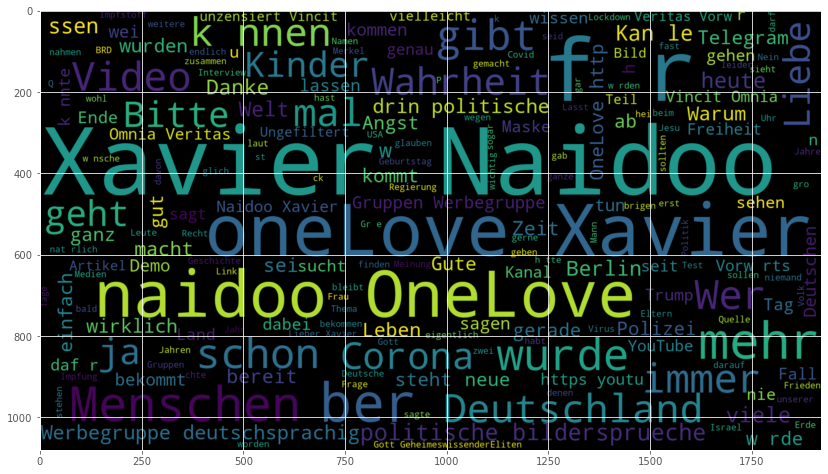

[Stopwatch stopped >>Word Cloud<< (6.711s)]


In [80]:
# Xavier Naidoo (public_channel - dataSet0)
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
        "wordcloud-xavier-naidoo.png",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud

Top 20 occ:
f r              1.000000
ber              0.294651
mehr             0.252667
Deutschland      0.210066
Menschen         0.196676
wurde            0.191233
k nnen           0.169062
gibt             0.150047
schon            0.138834
immer            0.135496
Video            0.134915
sei              0.128239
geht             0.119566
sagte            0.117207
heute            0.115357
Corona           0.110785
Xavier Naidoo    0.110748
ssen             0.105378
mal              0.100878
wurden           0.098846
dtype: float64

- Start generate figure


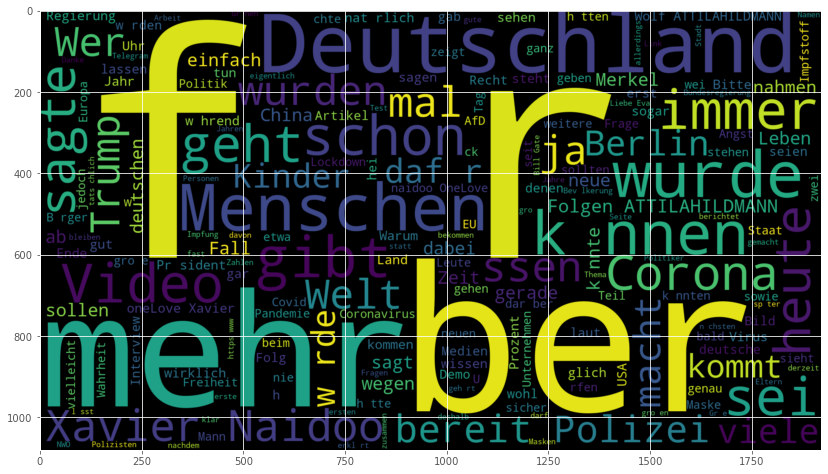

[Stopwatch stopped >>Word Cloud<< (28.107s)]


In [81]:
# Just for test purposes
if(FLAG_SHORT_RUN == False):
    generateWordCloud(
        dfAllDataMessages,
        "",
        [],
        flagShow = True,
        configPlotWidth = 1920,
        configPlotHeight = 1080
    )

### Auto Mode (Batch)

In [82]:
def extractTimePeriodDataFrame(df, timeStart, timeStop):

    print("- Got Start " + str(timeStart) + " and Stop " + str(timeStop))

    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    
    dfNew = df[df.date <= timeStop]
    dfNew = dfNew[dfNew.date >= timeStart]

    dfNew = dfNew.set_index("date")
    dfNew = dfNew.sort_index()

    return dfNew

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
def generateWCPeriod():
    return list(pd.date_range( #m/d/y
            start='1/1/2018',
            end='2/1/2021',
            #freq="W-MON",
            freq="1M"
            ))

In [84]:
"""
Wrapper WordCloud

param   fP  filePath
param   label e.g. chatName
param   filterList additional stopWords
"""
def generateWordCloudAuto(fP, label, filterList):

    gloStartStopwatch("Generate World Cloud Auto >>" + fP + "<<")

    periods = generateWCPeriod()

    dictSaved = {}

    prevStart = periods[0]

    for period in periods:

        stop = period

        e = extractTimePeriodDataFrame(dictMessages[fP], timeStart = prevStart, timeStop = stop)

        if(prevStart != stop and len(e.index) > 0):
            fileName = "autoWordCloud/" + queryChatName(fP) + "-" + str(prevStart) + "-" + str(stop) + ".png"
            generateWordCloud(
                e,
                fileName,
                filterList,
                flagShow = False,
                configPlotWidth = 1280,
                configPlotHeight = 720
            )
            print("- Save file " + fileName)
            dictSaved[fileName] = str(prevStart) + " - " + str(stop)

        else:
            print("- Start and Stop equal or no message found")

        prevStart = stop

    gloWriteDictToFile("auto-wordcloud-" + label + ".csv", dictSaved)

    gloStopStopwatch("Generate World Cloud Auto >>" + fP + "<<")

In [85]:
if(FLAG_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-janich",
        label = "oliver-janich",
        filterList = []
    )

[Stopwatch started >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
- Got Start 2018-01-31 00:00:00 and Stop 2018-01-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-01-31 00:00:00 and Stop 2018-02-28 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-02-28 00:00:00 and Stop 2018-03-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-03-31 00:00:00 and Stop 2018-04-30 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-04-30 00:00:00 and Stop 2018-05-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-05-31 00:00:00 and Stop 2018-06-30 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-06-30 00:00:00 and Stop 2018-07-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-07-31 00:00:00 and Stop 2018-08-31 00:00:00
[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud
[Stopwatch 

- Start transform text to global text string
- Start generate cloud
[Stopwatch stopped >>Word Cloud<< (2.422s)]
- Save file autoWordCloud/Oliver Janich ffentlich-2020-07-31 00:00:00-2020-08-31 00:00:00.png
- Got Start 2020-08-31 00:00:00 and Stop 2020-09-30 00:00:00
[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud
[Stopwatch stopped >>Word Cloud<< (2.607s)]
- Save file autoWordCloud/Oliver Janich ffentlich-2020-08-31 00:00:00-2020-09-30 00:00:00.png
- Got Start 2020-09-30 00:00:00 and Stop 2020-10-31 00:00:00
[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud
[Stopwatch stopped >>Word Cloud<< (2.611s)]
- Save file autoWordCloud/Oliver Janich ffentlich-2020-09-30 00:00:00-2020-10-31 00:00:00.png
- Got Start 2020-10-31 00:00:00 and Stop 2020-11-30 00:00:00
[Stopwatch started >>Word Cloud<<]
- Start transform text to global text string
- Start generate cloud
[Stopwatch stopped >>Word 

In [86]:
if(FLAG_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-hildmann",
        label = "attila-hildmann",
        filterList = []
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]
- Got Start 2018-01-31 00:00:00 and Stop 2018-01-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-01-31 00:00:00 and Stop 2018-02-28 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-02-28 00:00:00 and Stop 2018-03-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-03-31 00:00:00 and Stop 2018-04-30 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-04-30 00:00:00 and Stop 2018-05-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-05-31 00:00:00 and Stop 2018-06-30 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-06-30 00:00:00 and Stop 2018-07-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-07-31 00:00:00 and Stop 2018-08-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-08-31 00:00:00 and Stop 2018-09-30 00:00:00
- Start 

In [87]:
if(FLAG_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-evaherman",
        label = "eva-herman",
        filterList = []
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<<<]
- Got Start 2018-01-31 00:00:00 and Stop 2018-01-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-01-31 00:00:00 and Stop 2018-02-28 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-02-28 00:00:00 and Stop 2018-03-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-03-31 00:00:00 and Stop 2018-04-30 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-04-30 00:00:00 and Stop 2018-05-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-05-31 00:00:00 and Stop 2018-06-30 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-06-30 00:00:00 and Stop 2018-07-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-07-31 00:00:00 and Stop 2018-08-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-08-31 00:00:00 and Stop 2018-09-30 00:00:00
- Start

In [88]:
if(FLAG_SHORT_RUN == False):
    generateWordCloudAuto(
        fP = "DS-05-01-2021/ChatExport_2021-01-05-xavier",
        label = "xavier-naidoo",
        filterList = []
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Generate World Cloud Auto >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<<<]
- Got Start 2018-01-31 00:00:00 and Stop 2018-01-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-01-31 00:00:00 and Stop 2018-02-28 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-02-28 00:00:00 and Stop 2018-03-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-03-31 00:00:00 and Stop 2018-04-30 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-04-30 00:00:00 and Stop 2018-05-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-05-31 00:00:00 and Stop 2018-06-30 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-06-30 00:00:00 and Stop 2018-07-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-07-31 00:00:00 and Stop 2018-08-31 00:00:00
- Start and Stop equal or no message found
- Got Start 2018-08-31 00:00:00 and Stop 2018-09-30 00:00:00
- Start an

## N Grams

In [89]:
def generateNGram(text, n):
    # https://albertauyeung.github.io/2018/06/03/generating-ngrams.html
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    tokens = [token for token in text.split(" ") if token != ""]
    
    return list(ngrams(tokens, n))

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
def generateNGramChat(fP, n, mostCommon):
    return Counter(
        generateNGram(
            generateTextFromChat(dictMessages[fP]),
            n = n
        )
    ).most_common(mostCommon)

In [91]:
def generateNGramAuto(filePathList, n, mostCommon):
    for fP in filePathList:

        print()
        print("Analyse now >>" + fP + "<<")

        c = generateNGramChat(
            fP,
            n = n,
            mostCommon = mostCommon
        )

        print ("\n".join(map(str, c)))

In [92]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 2,
    mostCommon = 10
)


Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('f', 'r'), 4750)
(('folgen', 'attilahildmann'), 2061)
(('dem', 'wolf'), 1709)
(('wolf', 'attilahildmann'), 1708)
(('folg', 'dem'), 1707)
(('in', 'der'), 1344)
(('und', 'die'), 997)
(('r', 'die'), 823)
(('in', 'den'), 805)
(('es', 'ist'), 804)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('f', 'r'), 11329)
(('in', 'der'), 4133)
(('in', 'den'), 2359)
(('r', 'die'), 2244)
(('k', 'nnen'), 1804)
(('und', 'die'), 1626)
(('dass', 'die'), 1580)
(('von', 'der'), 1377)
(('auf', 'die'), 1338)
(('mit', 'der'), 1282)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<
(('f', 'r'), 8877)
(('in', 'der'), 3070)
(('in', 'den'), 1786)
(('k', 'nnen'), 1620)
(('r', 'die'), 1531)
(('und', 'die'), 1285)
(('auf', 'die'), 1085)
(('mit', 'dem'), 1002)
(('dass', 'die'), 975)
(('von', 'der'), 953)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-xavier<<
(('xavier', 'naidoo'), 2879)
(('f', 'r'), 2326)
(('onelove', 'xavie

In [93]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 3,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('dem', 'wolf', 'attilahildmann'), 1708)
(('folg', 'dem', 'wolf'), 1707)
(('f', 'r', 'die'), 807)
(('https', 't', 'me'), 687)
(('attilahildmann', 'chat', 'beitreten'), 504)
(('wolf', 'attilahildmann', 'chat'), 501)
(('chat', 'beitreten', 'chatderfreiheit'), 499)
(('https', 'youtu', 'be'), 468)
(('das', 'deutsche', 'volk'), 340)
(('teilen', 'folgen', 'attilahildmann'), 322)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('f', 'r', 'die'), 2206)
(('f', 'r', 'den'), 896)
(('f', 'r', 'das'), 475)
(('hei', 't', 'es'), 461)
(('f', 'r', 'eine'), 421)
(('in', 'den', 'usa'), 249)
(('f', 'r', 'einen'), 228)
(('f', 'r', 'ein'), 223)
(('f', 'r', 'alle'), 210)
(('die', 'gr', 'nen'), 207)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-evaherman<<
(('f', 'r', 'die'), 1509)
(('f', 'r', 'den'), 675)
(('eva', 'lieber', 'andreas'), 384)
(('liebe', 'eva', 'lieber'), 383)
(('f', 'r', 'das'), 371)
(('danke', 'f', 'r'), 347)
(('

In [94]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 4,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('folg', 'dem', 'wolf', 'attilahildmann'), 1707)
(('dem', 'wolf', 'attilahildmann', 'chat'), 501)
(('wolf', 'attilahildmann', 'chat', 'beitreten'), 501)
(('attilahildmann', 'chat', 'beitreten', 'chatderfreiheit'), 496)
(('www', 'attilahildmann', 'de', 'alles'), 228)
(('attilahildmann', 'de', 'alles', 'pc'), 228)
(('folgt', 'uns', 'auf', 'gerechtigkeitfuersvaterland'), 207)
(('de', 'alles', 'pc', 'topbioneu'), 185)
(('b', 'nai', 'b', 'rith'), 179)
(('zum', 'ersten', 'mal', 'bei'), 166)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('und', 'kommentierung', 'meiner', 'videos'), 194)
(('kommentierung', 'meiner', 'videos', 'im'), 194)
(('meiner', 'videos', 'im', 'premium'), 194)
(('videos', 'im', 'premium', 'kanal'), 194)
(('fr', 'hzugriff', 'und', 'kommentierung'), 192)
(('hzugriff', 'und', 'kommentierung', 'meiner'), 191)
(('exklusive', 'inhalte', 'fr', 'hzugriff'), 181)
(('inhalte', 'fr', 'hzugriff', 'und'), 17

In [95]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 5,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('folg', 'dem', 'wolf', 'attilahildmann', 'chat'), 501)
(('dem', 'wolf', 'attilahildmann', 'chat', 'beitreten'), 501)
(('wolf', 'attilahildmann', 'chat', 'beitreten', 'chatderfreiheit'), 493)
(('www', 'attilahildmann', 'de', 'alles', 'pc'), 228)
(('attilahildmann', 'de', 'alles', 'pc', 'topbioneu'), 185)
(('zum', 'ersten', 'mal', 'bei', 'mir'), 166)
(('5', 'gutschein', 'f', 'r', 'alle'), 152)
(('die', 'zum', 'ersten', 'mal', 'bei'), 152)
(('gutschein', 'f', 'r', 'alle', 'die'), 149)
(('f', 'r', 'alle', 'die', 'zum'), 149)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('kommentierung', 'meiner', 'videos', 'im', 'premium'), 194)
(('meiner', 'videos', 'im', 'premium', 'kanal'), 194)
(('fr', 'hzugriff', 'und', 'kommentierung', 'meiner'), 191)
(('hzugriff', 'und', 'kommentierung', 'meiner', 'videos'), 191)
(('und', 'kommentierung', 'meiner', 'videos', 'im'), 190)
(('exklusive', 'inhalte', 'fr', 'hzugriff', 'und'),

In [96]:
generateNGramAuto(
    dfInputFiles[dfInputFiles.inputDesc == "dataSet0"].inputPath,
    n = 6,
    mostCommon = 10
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<
(('folg', 'dem', 'wolf', 'attilahildmann', 'chat', 'beitreten'), 501)
(('dem', 'wolf', 'attilahildmann', 'chat', 'beitreten', 'chatderfreiheit'), 493)
(('www', 'attilahildmann', 'de', 'alles', 'pc', 'topbioneu'), 185)
(('die', 'zum', 'ersten', 'mal', 'bei', 'mir'), 152)
(('gutschein', 'f', 'r', 'alle', 'die', 'zum'), 149)
(('f', 'r', 'alle', 'die', 'zum', 'ersten'), 149)
(('r', 'alle', 'die', 'zum', 'ersten', 'mal'), 149)
(('5', 'gutschein', 'f', 'r', 'alle', 'die'), 148)
(('alle', 'die', 'zum', 'ersten', 'mal', 'bei'), 148)
(('zum', 'ersten', 'mal', 'bei', 'mir', 'bestellen'), 145)

Analyse now >>DS-05-01-2021/ChatExport_2021-01-05-janich<<
(('kommentierung', 'meiner', 'videos', 'im', 'premium', 'kanal'), 194)
(('fr', 'hzugriff', 'und', 'kommentierung', 'meiner', 'videos'), 191)
(('und', 'kommentierung', 'meiner', 'videos', 'im', 'premium'), 190)
(('hzugriff', 'und', 'kommentierung', 'meiner', 'videos', 'im'), 187)
(('exklu

## Topic Modeling

Overview Topic Modeling
https://nlpforhackers.io/topic-modeling/

- LDA (Probabilistic Graphical Models)
- LSA or LSI (Linear Algebra Singular Value Decomposition)
- NMF (Linear Algebra Non-Negative Matrix Factorization)

### Latent Dirichlet Allocation (LDA) with Gensim

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [97]:
# TODO: Get clean words from it (arrays)
def sendToWords(sentences):
    for sentence in sentences:
        # deacc= removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def removeStopwords(texts, stop_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
"""
return  (lda_model, corpus, id2word)
"""
def processLda(df, num_topics, debugPrint, filterList):

    df = df.copy()

    df = df[df.procEvalIsValidText == True]

    df = df[["date", "procTDSafeLowercaseText"]]

    df = df.set_index("date")
    df = df.sort_index()

    # ###############################
    # ### Transform Data ############
    # ###############################
    stops_words = getStopWordsList(filterList)

    msgList     = df.procTDSafeLowercaseText.values.tolist()

    # Create words
    # TODO: Create token and remo unicode (maybe change prior) 
    msg_words   = list(sendToWords(msgList))
    msg_word    = removeStopwords(texts = msg_words, stop_words = stops_words)

    # Create Dictionary (id to word)
    id2word = corpora.Dictionary(msg_word)

    # Create Corpus
    texts = msg_word

    # Term Document Frequency (dict to bag of words)
    corpus = [id2word.doc2bow(text) for text in texts]

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

    if(debugPrint):
        pprint(lda_model.print_topics())
        #doc_lda = lda_model[corpus] # TODO: ?

    return (lda_model, corpus, id2word)

In [99]:
"""
param   outputLabel required
"""
def ldaToHtml(lda_model, corpus, id2word, outputLabel):

    # pyLDAvis.enable_notebook()

    LDAvis_data_filepath = os.path.join(dir_var_output + 'pyLDAvis/' + outputLabel + '-data')

    # # this is a bit time consuming - make the if statement True
    # # if you want to execute visualization prep yourself
    if 1 == 1:
        LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
        with open(LDAvis_data_filepath, 'wb') as f:
            pickle.dump(LDAvis_prepared, f)

    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

    pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')

In [100]:
# param outputLabel required
def autoLda(df, num_topics, debugPrint, outputLabel, filterList):

    gloStartStopwatch("Process LDA >> "+ outputLabel + "<<")
    lda_model, corpus, id2word = processLda(
        df = df,
        num_topics = num_topics,
        debugPrint = debugPrint,
        filterList = filterList
    )
    gloStopStopwatch("Process LDA >> "+ outputLabel + "<<")

    gloStartStopwatch("Process LDA to html >> "+ outputLabel + "<<")
    ldaToHtml(
        lda_model = lda_model,
        corpus = corpus,
        id2word = id2word,
        outputLabel = outputLabel
    )
    gloStopStopwatch("Process LDA to html >> "+ outputLabel + "<<")

In [101]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-janich"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "oliver-janich",
    filterList = []
)

[Stopwatch started >>Process LDA >> oliver-janich<<<<]
[(0,
  '0.007*"ber" + 0.005*"mehr" + 0.004*"corona" + 0.004*"gr" + '
  '0.004*"deutschland" + 0.003*"schon" + 0.003*"sch" + 0.003*"bitte" + '
  '0.003*"wurde" + 0.003*"sei"'),
 (1,
  '0.006*"corona" + 0.005*"ber" + 0.003*"gro" + 0.003*"mehr" + 0.003*"en" + '
  '0.003*"prozent" + 0.003*"menschen" + 0.003*"gr" + 0.002*"sei" + '
  '0.002*"sagte"'),
 (2,
  '0.005*"ber" + 0.004*"mehr" + 0.004*"corona" + 0.003*"deutschland" + '
  '0.003*"wurde" + 0.002*"immer" + 0.002*"pr" + 0.002*"menschen" + 0.002*"gro" '
  '+ 0.002*"sei"'),
 (3,
  '0.005*"ber" + 0.004*"wurde" + 0.004*"trump" + 0.003*"mehr" + 0.003*"gr" + '
  '0.003*"video" + 0.002*"gibt" + 0.002*"corona" + 0.002*"gef" + '
  '0.002*"deutschland"'),
 (4,
  '0.004*"mehr" + 0.004*"menschen" + 0.004*"wurde" + 0.004*"ber" + '
  '0.003*"schon" + 0.003*"corona" + 0.003*"ren" + 0.003*"sei" + 0.003*"gibt" + '
  '0.003*"sagte"')]
[Stopwatch stopped >>Process LDA >> oliver-janich<<<< (30.771s)]
[

<ipython-input-99-4ac582c2e7ec>:21: ResourceWarning: unclosed file <_io.TextIOWrapper name='./output/pyLDAvis/oliver-janich-report.html' mode='w' encoding='UTF-8'>
  pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')


[Stopwatch stopped >>Process LDA to html >> oliver-janich<<<< (25.746s)]


In [102]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-hildmann"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "attila-hildmann",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Process LDA >> attila-hildmann<<<<]
[(0,
  '0.013*"attilahildmann" + 0.005*"folgen" + 0.005*"ber" + 0.005*"corona" + '
  '0.004*"mehr" + 0.004*"menschen" + 0.004*"deutschland" + 0.004*"schon" + '
  '0.003*"wolf" + 0.003*"sch"'),
 (1,
  '0.010*"attilahildmann" + 0.006*"ber" + 0.006*"merkel" + 0.006*"wolf" + '
  '0.005*"mal" + 0.005*"corona" + 0.005*"folg" + 0.005*"gates" + '
  '0.005*"menschen" + 0.004*"video"'),
 (2,
  '0.025*"attilahildmann" + 0.012*"folgen" + 0.007*"deutschland" + '
  '0.006*"teilen" + 0.005*"https" + 0.005*"menschen" + 0.004*"mehr" + '
  '0.004*"folg" + 0.004*"schon" + 0.004*"wolf"'),
 (3,
  '0.015*"attilahildmann" + 0.008*"https" + 0.006*"de" + 0.005*"www" + '
  '0.004*"deutsche" + 0.004*"chat" + 0.003*"folgen" + 0.003*"heute" + '
  '0.003*"freimaurer" + 0.003*"deutschen"'),
 (4,
  '0.008*"attilahildmann" + 0.007*"gates" + 0.006*"deutschland" + 0.005*"ber" '
  '+ 0.005*"https" + 0.004*"merkel" + 0.004*"schon" + 0.003*"mehr" + '
  '0.003*"mensch

<ipython-input-99-4ac582c2e7ec>:21: ResourceWarning: unclosed file <_io.TextIOWrapper name='./output/pyLDAvis/attila-hildmann-report.html' mode='w' encoding='UTF-8'>
  pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')


[Stopwatch stopped >>Process LDA to html >> attila-hildmann<<<< (13.476s)]


In [103]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-evaherman"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "eva-herman",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Process LDA >> eva-herman<<<<]
[(0,
  '0.008*"ber" + 0.005*"menschen" + 0.004*"corona" + 0.004*"pr" + 0.004*"gr" + '
  '0.004*"liebe" + 0.003*"schon" + 0.003*"mehr" + 0.003*"nnen" + '
  '0.003*"immer"'),
 (1,
  '0.006*"mehr" + 0.005*"ber" + 0.004*"corona" + 0.004*"trump" + '
  '0.004*"menschen" + 0.004*"wurde" + 0.003*"gr" + 0.003*"eva" + 0.003*"gro" + '
  '0.003*"viele"'),
 (2,
  '0.007*"ber" + 0.005*"corona" + 0.004*"mehr" + 0.004*"menschen" + '
  '0.003*"gro" + 0.003*"gr" + 0.003*"wurde" + 0.003*"leben" + 0.002*"seit" + '
  '0.002*"herman"'),
 (3,
  '0.006*"liebe" + 0.005*"ber" + 0.005*"mehr" + 0.004*"heute" + 0.004*"immer" '
  '+ 0.003*"gibt" + 0.003*"corona" + 0.003*"sch" + 0.003*"andreas" + '
  '0.003*"eva"'),
 (4,
  '0.006*"ber" + 0.004*"menschen" + 0.003*"wurde" + 0.003*"corona" + '
  '0.003*"mehr" + 0.003*"leserzuschrift" + 0.003*"deutschland" + 0.003*"nnen" '
  '+ 0.002*"heute" + 0.002*"zuschrift"')]
[Stopwatch stopped >>Process LDA >> eva-herman<<<< (18.

<ipython-input-99-4ac582c2e7ec>:21: ResourceWarning: unclosed file <_io.TextIOWrapper name='./output/pyLDAvis/eva-herman-report.html' mode='w' encoding='UTF-8'>
  pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')


[Stopwatch stopped >>Process LDA to html >> eva-herman<<<< (12.162s)]


In [104]:
autoLda(
    df = dictMessages["DS-05-01-2021/ChatExport_2021-01-05-xavier"],
    num_topics = 5,
    debugPrint = True,
    outputLabel = "xavier-naidoo",
    filterList = []
)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Process LDA >> xavier-naidoo<<<<]
[(0,
  '0.006*"mehr" + 0.005*"ber" + 0.003*"xavier" + 0.003*"bitte" + 0.003*"immer" '
  '+ 0.003*"menschen" + 0.003*"berlin" + 0.003*"sch" + 0.002*"naidoo" + '
  '0.002*"kinder"'),
 (1,
  '0.040*"xavier" + 0.036*"naidoo" + 0.034*"onelove" + 0.004*"menschen" + '
  '0.004*"https" + 0.003*"liebe" + 0.003*"ber" + 0.003*"nnen" + 0.003*"gibt" + '
  '0.003*"mehr"'),
 (2,
  '0.019*"xavier" + 0.018*"naidoo" + 0.014*"onelove" + 0.004*"ber" + '
  '0.004*"schon" + 0.003*"gibt" + 0.003*"menschen" + 0.003*"heute" + '
  '0.003*"liebe" + 0.003*"mehr"'),
 (3,
  '0.007*"xavier" + 0.005*"drin" + 0.005*"politische" + 0.005*"gruppen" + '
  '0.005*"naidoo" + 0.005*"le" + 0.005*"bildersprueche" + 0.004*"kan" + '
  '0.004*"onelove" + 0.004*"schon"'),
 (4,
  '0.007*"ber" + 0.005*"mehr" + 0.005*"corona" + 0.004*"xavier" + '
  '0.004*"wurde" + 0.003*"menschen" + 0.003*"gr" + 0.003*"naidoo" + '
  '0.003*"deutschland" + 0.003*"schon"')]
[Stopwatch stopped >>Pr

<ipython-input-99-4ac582c2e7ec>:21: ResourceWarning: unclosed file <_io.TextIOWrapper name='./output/pyLDAvis/xavier-naidoo-report.html' mode='w' encoding='UTF-8'>
  pyLDAvis.save_html(LDAvis_prepared, dir_var_output + 'pyLDAvis/' + outputLabel + '-report.html')


[Stopwatch stopped >>Process LDA to html >> xavier-naidoo<<<< (5.462s)]


In [105]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChat"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-freiheitsChat",
        filterList = []
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-freiheitsChatBlitz"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-freiheitsChatBlitz",
        filterList = []
    )

In [107]:
if("dataSet1a" in C_LOAD_DATASET):
    autoLda(
        df = dictMessages["DS-05-01-2021a/ChatExport_2021-01-05-liveFuerDeOsSc"],
        num_topics = 25,
        debugPrint = True,
        outputLabel = "group-liveFuerDeOsSc",
        filterList = []
    )

## Word Tracer

In [108]:
# TODO: Add freq words
highlightwords = ["Corona", "Merkel", "Gates", "Wahrheit", "Angst", "Polizei", "Kinder"]

[Stopwatch started >>Time Plot<<]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<<]
[Stopwatch stopped >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-janich<<<< (1011.600s)]
[Stopwatch stopped >>Time Plot<< (1011.880s)]


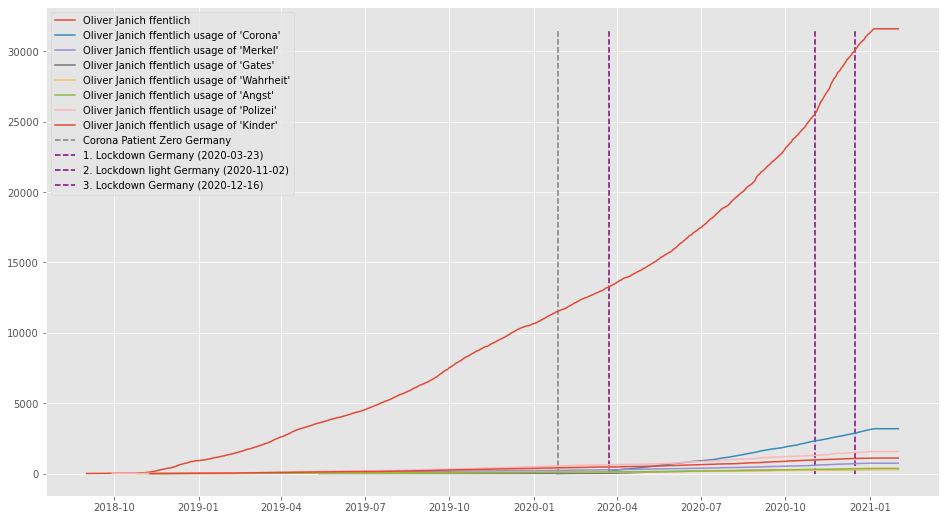

In [109]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-janich"]),
        outputFilename = "word-tracer-oliver-janich.png",
        highlightWords = highlightwords
    )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Stopwatch started >>Time Plot<<]
[Stopwatch started >>Time Plot >>DS-05-01-2021/ChatExport_2021-01-05-hildmann<<<<]


KeyboardInterrupt: 

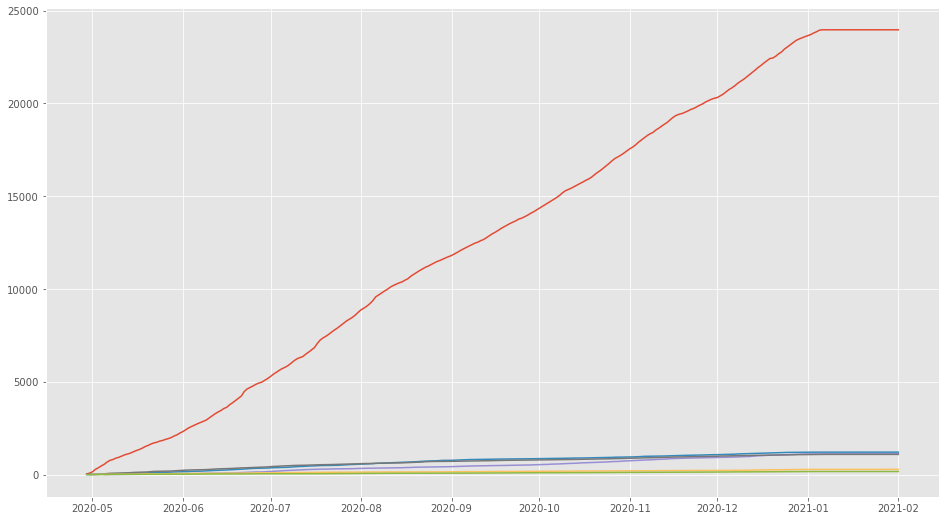

In [110]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-hildmann"]),
        outputFilename = "word-tracer-attila-hildmann.png",
        highlightWords = highlightwords
    )

In [ ]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-evaherman"]),
        outputFilename = "word-tracer-eva-herman.png",
        highlightWords = highlightwords
    )

In [ ]:
if(FLAG_SHORT_RUN == False):
    drawTimePlot(
        filePathList = list(["DS-05-01-2021/ChatExport_2021-01-05-xavier"]),
        outputFilename = "word-tracer-xavier-naidoo.png",
        highlightWords = highlightwords
    )

## Future Stuff

In [ ]:
gloStopStopwatch("Global notebook")

In [ ]:
# Next Steps
"""
- Add freq words to word tracer
- Python NatrualLanguage Toolkit tools?
"""

In [ ]:
# https://towardsai.net/p/data-mining/text-mining-in-python-steps-and-examples-78b3f8fd913b
"""
- Concordance (and Kookkurrenz and Correl?)
- Tokenization
- Finding frequency distinct in the text
- Stemming
- Lemmatization
- Stop words?
- Part of speech tagging (POS)
- Named entity recognition
- Chunking
"""

# https://towardsdatascience.com/text-mining-for-dummies-text-classification-with-python-98e47c3a9deb
"""
- Sentiment Analysis
"""

# https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
"""
- Features: (Number of words, Number of characters, Average word length, Number of stopwords, Number of special characters, Number of nummberics, Number of uppercase words)
- Pre-processing (Lower casing, Punctuation removal, Stopwrods removal, Frequent word removal, Rare words removal, Spelling correction, Tokenization, Stemming, Lemmatization)
- Adv-processing (N-grams, Term Frequency, Inverse Document Frequency, Term Frequency-Inverse Document Frequency 'TF-IDF', Bag of words, Sentiment Analysis, Word Embedding)
"""

# https://realpython.com/python-keras-text-classification/
"""
- Text Analysis with Keras
"""

# https://www.tidytextmining.com/ngrams.html
"""
- Relationships between words: n-grams and correlations
"""

# http://seaborn.pydata.org/tutorial/categorical.html?highlight=bar%20plot
"""
- Plotting with categorical data (Box Plot)
"""

# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
"""
- Visualizing Data with Pairs Plots in Python
"""

# https://www.kirenz.com/post/2019-08-13-network_analysis/
"""
- Social Network Analysis with Python
"""

# https://tgstat.com
"""
- Compare website with my analyse
"""

# https://huggingface.co/bert-base-german-cased
"""
- Language Model Bert German
"""

# https://github.com/sekhansen/text-mining-tutorial/tree/master
"""
- An Introduction to Topic Modelling via Gibbs sampling
"""

# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
"""
- Topic Modeling with Gensim (Python)
"""

# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
"""
- Topic Modeling in Python: Latent Dirichlet Allocation (LDA)
"""

# https://github.com/sekhansen/text-mining-tutorial/blob/master/tutorial_notebook.ipynb
"""
- Text Mining Python Tutorial
"""

# https://textmining.wp.hs-hannover.de/Preprocessing.html
"""
- Preprocessing samples
"""

# https://likegeeks.com/nlp-tutorial-using-python-nltk/
"""
- NLTK and NLP Tutorial
"""

# https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
"""
- Another NLTK Tutorial
"""

# https://data-flair.training/blogs/nltk-python-tutorial/
"""
- NLTK Overview
"""

# https://github.com/expectocode/telegram-analysis
"""
- Telegram Python Sample
"""